# Assignment 2 - Pump it Up
## Laurens ten Cate, Annie Pi - MBD'18 - Machine Learning II

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import numpy as np
import seaborn as sns

In [3]:
train_values = pd.read_csv("train_values.csv")
train_labels = pd.read_csv("train_labels.csv")
test_values = pd.read_csv("test_values.csv")

# 1. Data Preparation

## Introduction

**DrivenData notes**

- DrivenData username: Laurens-Annie
- DrivenData final best score: 0.8223
- DrivenData final best rank: 183

**Final Delivery notes**

This notebook uses a dataset from the Taarifa waterpoints dashboard, which aggegrates data from the Tanzania Ministry of Water. The competition requires us to predict which waterpumps are functional, which need repairs and which are broken. For more information see: https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/

The notebook is structured as follows.

1. Data Preperation
    - Id Column
    - Train Labels
2. Data Cleaning & Preprocessing
    - Incorrect values
    - Similar Variables / Values
    - Factorization / de-Factorization
    - Level Reduction
    - NA imputation
    - Transformations
    - Incomplete Cases
    - Factor Level Reduction
3. Feature Engineering
    - Baseline Model
    - Feature Construction
        - New Features
        - Genetic Programming
    - Creating Dummies
    - Overfit Prevention
        - Local Outlier Factor - Outlier Detection
        - Dummy Levels
4. Modelling
    - Optimized Random Forest
    - Discriminant Analysis
        - LDA (+PCA)
        - QDA
    - (Bayesian) Optimized XGBoost
5. Ensemble methods
    - Stacked Generalizations
    - Ensemble Voting Classification
        - Hard Voting
6. Predictions

The notebook is a snapshot of how I achieved my final score. Everything in here 'helped' and thus a lot of other methods I tried are excluded. Below is a list of things I tried beside the methods used in the notebook. 

**Preprocessing**

- MICE NA imputation
- Label encoding

**Feature engineering**

- Recoding various variables
- PCA on numericals
- MCE on categoricals to combine dummies of categoricals with high amount of levels.
- Various iterations of genetic algorithms
- Polynomial and interaction features
- Various binning methods until I settled on decision trees

**Modelling**

- non-linear kernel SVM. Was too slow to be feasible.
- Adaboost - not effective
- Genetic feature selection - way way too slow. I ran it for two days but had to pull the plug to focus on other methods.

Besides all this a lot of time was spent optimizing hyperparameters (gridsearches and bayesian optimization), and playing with ensembles. I definitely think I could get some more gains by training and optimizing more models to increase my probability based voting effectiveness. 

In the end I believe my best work is in factor level reduction, specifically I gained a lot by combining similar levels through using Levenshtein distance.


## IMPORTANT NOTE ##
Due to problems with extremely large outputs, I used a custom html output template to hide output in the HTML export. This will show up as a small box beneath each code block that has output. If you click it the output will appear. This was done because my custom cleaning functions have massive verbosity to keep an eye on whats going on which took up too much space in the HTML output. If you prefer reading with all output automatically open, see the second HTML file.

## 1.1 Inspect train and test

In [4]:
print(len(np.unique(train_values['id'])) == len(train_values))
print(len(np.unique(test_values['id'])) == len(test_values))
print(len(np.unique(train_labels['id'])) == len(train_labels))

True
True
True


All three datasets have unique IDs for each row, so it's safe to remove the id column. But first I'll use id to combine train_values and train_labels into a single dataframe to help with understanding the data.

In [5]:
train_values_and_labels = pd.merge(train_values, train_labels, on='id')

In [6]:
train = train_values.drop(['id'], axis=1)
test = test_values.drop(['id'], axis=1)
ytrain = train_labels.drop(['id'], axis=1)
train_full = train_values_and_labels.drop(['id'], axis=1)

In [7]:
train_full.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [8]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)
print("Train labels set size:", ytrain.shape)

Train set size: (59400, 39)
Test set size: (14850, 39)
Train labels set size: (59400, 1)


## 1.2 Train labels
Let's take a closer look at the target variable of this challenge. 

In [8]:
ytrain.iloc[:,0].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

The values seem to be decently spread, though "functional needs repair" represents only 7% of the dataset. I will need to be careful to use stratified k-fold cross-validation to make sure all folds have roughly equal amounts of all labels.

## 1.2 Concatenation
To keep consistency between test and train features during feature engineering we concatenate the two sets.

In [23]:
features = pd.concat([train, test]).reset_index(drop=True)
features.shape

(74250, 39)

# 2. Data Cleaning & Preprocessing

## 2.1 Incorrect values
We want to make sure that data going into the final model is as clean as possible, so let's first examine the numericals.

In [1262]:
numericals = features.select_dtypes(include=['float64', 'int64'])
numericals.head()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
0,6000.0,1390,34.938093,-9.856322,0,11,5,109,1999
1,0.0,1399,34.698766,-2.147466,0,20,2,280,2010
2,25.0,686,37.460664,-3.821329,0,21,4,250,2009
3,0.0,263,38.486161,-11.155298,0,90,63,58,1986
4,0.0,0,31.130847,-1.825359,0,18,1,0,0


In [1263]:
numericals.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


A few variables stand out.
- amount_tsh has an extremely high maximum value of 350,000 when the mean is only 318. 
- population has lots of 0 values, though of course this is not possible.
- construction_year has some 0 values, which i also not possible.
- gps_height looks suspicious due to the negative value as the minimum, but as this indicates the altitude of the well, it's possible that the negative value correspond to wells below sea level. 
- longitude has a zero value for the min. This doesn't make sense as Tanzania's longitude range is 29.6 to 40.3 (http://latitudelongitude.org/tz/)
- numprivate has mostly 0 values, though its max is 1776.

Let's take a look at these individually and fix all the wrong values.

#### amount_tsh
Let's look at a histogram of the distribution.

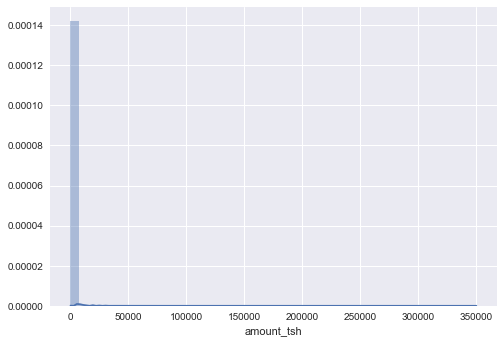

In [1264]:
sns.distplot(features.amount_tsh)

Clearly there is a massive issue with zeros here. The data source says that amount_tsh means the amount of water available to the pump, so zero could be a missing value or it could indicate the well is non-functional. To check this, I plot the distribution of target values in my full training set where amount=0. 

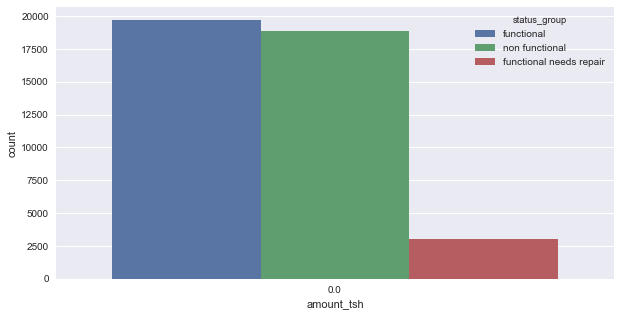

In [34]:
plt.subplots(figsize=(10,5))
sns.countplot(x="amount_tsh", hue="status_group", data=train_full[train_full['amount_tsh'] == 0])

It looks like the values are split almost evenly between functional and non-functional, so we cannot make assumptions about what the zero value means. So we will deal this later by imputing it later in our NA strategy.

In [1265]:
features.loc[features['amount_tsh'] == 0, 'amount_tsh'] = np.nan

In [1266]:
features.amount_tsh.isnull().sum()

52049

#### population
Let's look at a histogram of the distribution.

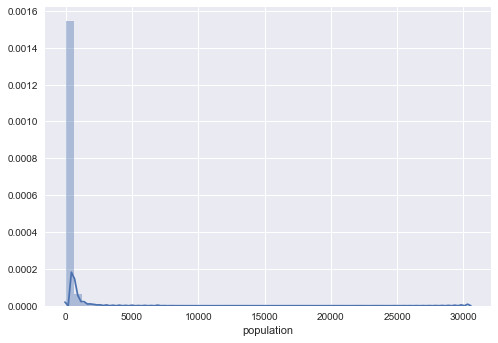

In [1267]:
sns.distplot(features.population)

Again, looks like the zero values should be NAs.

In [25]:
features.loc[features['population'] == 0, 'population'] = np.nan

In [26]:
features.population.value_counts().reset_index().sort_values(by='index').head(n=10)

,index,population
0,1.0,8782
313,2.0,9
401,3.0,6
215,4.0,15
90,5.0,50
135,6.0,27
545,7.0,3
130,8.0,29
255,9.0,12
39,10.0,203


Even though there are some very low value populations here, it is important to note that this is per well and it is possible that there are wells that are servicing only 1 or 2 people depending on how remote the region is.

#### construction_year
Let's check out the distribution.

In [1270]:
features.construction_year.value_counts().reset_index().sort_values(by='index').head(n=20)

,index,construction_year
0,0,25969
45,1960,124
52,1961,28
51,1962,36
46,1963,107
50,1964,48
53,1965,21
54,1966,19
47,1967,106
48,1968,93


Again, a lot of zero values which must be treated as NA's and imputed. For the rest it looks very clean with normal year values.

In [1271]:
features.loc[features['construction_year'] == 0, 'construction_year'] = np.nan

#### gps_height
Let's take a look at the distribution.

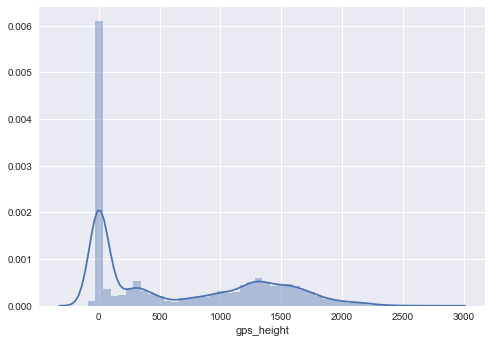

In [1272]:
sns.distplot(features.gps_height)

Again, there are a lots of zeros, though in this case it does not necessarily mean that they are missing as a gps height of 0 could just mean the well is at sea level. 

So let's groupby region and see where the zeros are concentrated. According to a map of Tanzania (https://www.wikiwand.com/en/Geography_of_Tanzania) only the area close to the sea is at sea level, while the rest is a lot higher than sea level. Looking at the region map (https://commons.wikimedia.org/wiki/File:Tanzania_regions.svg) it looks like only Pwani, Lindi and Mtwara are near the sea.

In [1273]:
height_group = features.groupby('region')['gps_height'].apply(lambda x : x.median())
height_group

region
Arusha           1400.0
Dar es Salaam      28.0
Dodoma              0.0
Iringa           1720.0
Kagera              0.0
Kigoma           1274.0
Kilimanjaro      1243.0
Lindi             232.5
Manyara          1483.0
Mara             1295.0
Mbeya               0.0
Morogoro          325.0
Mtwara            286.5
Mwanza              0.0
Pwani              46.0
Rukwa            1481.0
Ruvuma            918.0
Shinyanga           0.0
Singida          1482.0
Tabora              0.0
Tanga             295.0
Name: gps_height, dtype: float64

All the regions near the sea have higher levels. This probably means the zeros are missing values. Though I can't seperate actual zeros from NA's I am confident that my imputation method using KNN will approximate those rows that have actual zeros after the fact.

In [1299]:
features.loc[features['gps_height'] == 0, 'gps_height'] = np.nan

#### longitude
There are some zero values for the longitude. This doesn't make sense as Tanzania's longitude range is 29.6 to 40.3 (http://latitudelongitude.org/tz/). Let's take a look at the distribution.

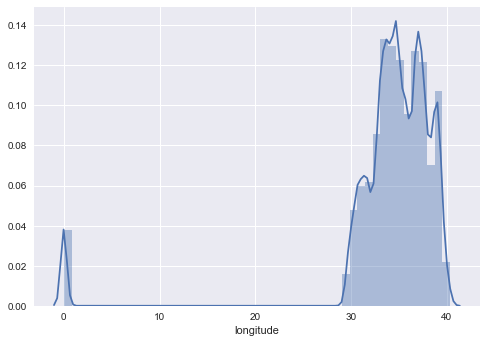

In [1274]:
sns.distplot(features.longitude)

Clearly the zero values are missing values here. Let's impute them.

In [1275]:
features.loc[features['longitude'] == 0, 'longitude'] = np.nan

#### latitude

C:\Users\Laurens\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


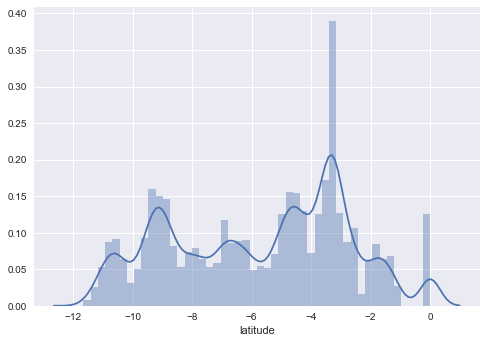

In [7]:
sns.distplot(features.latitude)

Looks like there are also some wrong values afor latitude round 0, since the range is -11 to -1. I will impute this later as well.

In [1430]:
features.latitude.value_counts().head()

-2.000000e-08    2269
-2.489090e+00       2
-6.981326e+00       2
-6.973930e+00       2
-2.485227e+00       2
Name: latitude, dtype: int64

In [1431]:
features.loc[features['latitude'] == -2.000000e-08, 'latitude'] = np.nan

#### num_private
Lets take a look at the distribution.

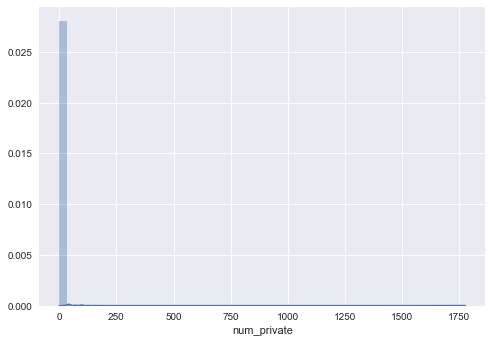

In [1276]:
sns.distplot(features.num_private)

Looks again like there are a lot of missing values. Unfortunately there is no information about what this variable is and it has an immense amount of missing values. I'll try to let KNN impute it but if it still doesn't make any sense, I'll probably delete it.

In [1277]:
features.loc[features['num_private'] == 0, 'num_private'] = np.nan

## 2.3 Similar Variables/values
Some of the columns seem to be very similar. Let's do an in-depth analysis to see which ones (if any) should be merged.

In [1278]:
features.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,NaN,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,NaN,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,NaN,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280.0,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,NaN,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,NaN,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,NaN,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,NaN,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,NaN,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


The columns that look very similar.

- recorded_by: Always has the same value so is irrelevant. We should drop it.
- payment_type & payment: These are exactly similar it seems according to value counts
- water_quality & quality_group: very similar except for a few levels - less granular?
- quantity & quantity_group: exactly the same according to value_counts
- source & source_type: very similar except for a few levels - less granular?
- waterpoint_type & waterpoint_type_group: very similar except for few levels - less granular?
- extraction_typ & extraction_type_group & extraction_class: very similar except for a few levels - les granular?

Column that seems too granular.

- wpt_name

Let's take a closer look at these pairs.

#### recorded_by

In [1279]:
features.recorded_by.value_counts()

GeoData Consultants Ltd    74250
Name: recorded_by, dtype: int64

This has 100% the same value and only indicates who the data was recorded by, so I drop the feature.

In [1280]:
features = features.drop(['recorded_by'], axis=1)

#### payment_type & payment

In [1281]:
features.payment_type.value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

In [1282]:
features.payment_type.value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

It seems that these two features are exactly the same. Just to be rigorous, let's check if this is not coincidental.

In [1283]:
check = pd.DataFrame(index = features.index)
check.loc[features.payment_type.isin(features.payment), 'check'] = False
np.sum(check.check)

0

Since they are exactly the same let's drop payment_type.

In [1284]:
features = features.drop(['payment_type'], axis=1)

#### water_quality & quality_group

In [1285]:
features.water_quality.value_counts()

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [1286]:
features.quality_group.value_counts()

good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

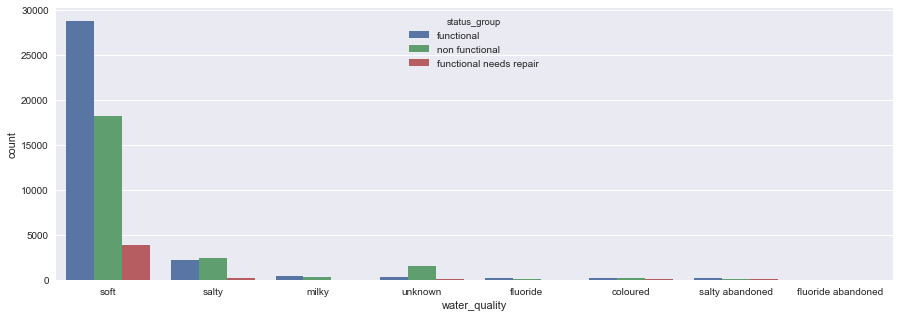

In [32]:
plt.subplots(figsize=(15,5))
sns.countplot(x="water_quality", hue="status_group", data=train_full)

The only difference is that water_quality is slightly more granular by splitting "salty" further into "salty abandoned" and "fluoride" into "fluoride abandoned." However, based on the distribution, it doesn't appear that these additional levels provide more variation in the target. I decide to keep both as regularization will take care of it if it's not a good predictor.

#### quantity & quantity_group

In [1287]:
features.quantity.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

In [1288]:
features.quantity_group.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

Looks very similar, but again, let's be rigorous and do a row by row check.

In [1289]:
check = pd.DataFrame(index = features.index)
check.loc[features.quantity.isin(features.quantity_group), 'check'] = False
np.sum(check.check)

0

Completely the same so let's drop quantity_group.

In [1290]:
features = features.drop(['quantity_group'], axis=1)

#### source & source_type

In [1291]:
features.source.value_counts()

spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

In [1292]:
features.source_type.value_counts()

spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: source_type, dtype: int64

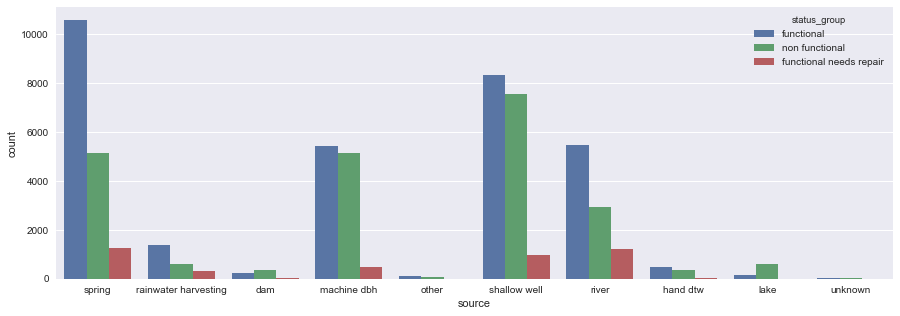

In [40]:
plt.subplots(figsize=(15,5))
sns.countplot(x="source", hue="status_group", data=train_full)

Looks very similar but source is slightly more granular - it looks like there may actually be a distinction between river and lake sources, with lake having more nonfunctional values, but I'll leave it be right now and let shrinkage methods deal with it. 

#### waterpoint_type & waterpoint_type_group

In [1294]:
features.waterpoint_type.value_counts()

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

In [1295]:
features.waterpoint_type_group.value_counts()

communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

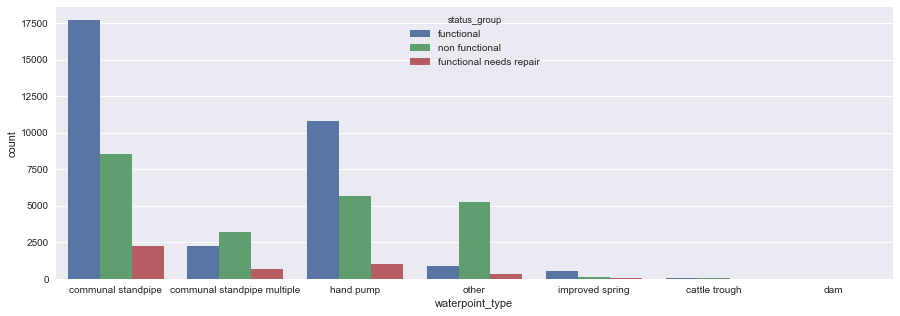

In [41]:
plt.subplots(figsize=(15,5))
sns.countplot(x="waterpoint_type", hue="status_group", data=train_full)

Looks very similar but waterpoint_type is slightly more granular with a distinction in the communal standpipe sublevel. It appears the communal standpipe multiple may have a higher proportion of nonfunctional values compared to just communal standpipe, but I'll leave it in for now and let regularization deal with it.

#### wpt_name

In [1473]:
features.wpt_name.value_counts().head(n=20)

none               4440
Shuleni            2183
Zahanati           1034
Msikitini           647
Kanisani            390
Sokoni              328
Bombani             323
Ofisini             321
School              260
Shule Ya Msingi     247
Shule               191
Sekondari           178
Muungano            159
Mkombozi            145
Upendo              130
Madukani            128
Mbugani             113
Kituo Cha Afya      113
Umoja               105
Mkuyuni             103
Name: wpt_name, dtype: int64

In [42]:
len(features.wpt_name.value_counts())

45684

This variable is the name of the waterpoint and has over 45,000 levels, which is probably too granular to be useful. Let's drop it for now.

In [1474]:
features = features.drop(['wpt_name'], axis=1)

#### extraction_type & extraction_type_group & extraction_type_class

In [129]:
features.extraction_type.value_counts()

gravity                      33263
nira/tanira                  10205
other                         8102
submersible                   5982
swn 80                        4588
mono                          3628
india mark ii                 3029
afridev                       2208
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [130]:
features.extraction_type_group.value_counts()

gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64

In [131]:
features.extraction_type_class.value_counts()

gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

Agan, very similar values, but with different levels of granularity. I don't want to lose any information by dropping any levels, so I'll keep them all.

## 2.4 Factorization
- region code shouldn't be numerical
- district code shouldn't be numerical
- construction year could be numerical or categorical, but better results were obtained by treating it as a categorical

In [1216]:
features.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,NaN,Lake Nyasa,Mnyusi B,Iringa,11.0,5.0,Ludewa,Mundindi,109.0,True,VWC,roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,NaN,Lake Victoria,Nyamara,Mara,20.0,2.0,Serengeti,Natta,280.0,NaN,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,NaN,Pangani,Majengo,Manyara,21.0,4.0,Simanjiro,Ngorika,250.0,True,VWC,nyumbayamungupipescheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,NaN,Ruvuma / Southern Coast,Mahakamani,Mtwara,90.0,63.0,Nanyumbu,Nanyumbu,58.0,True,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,NaN,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,NaN,Lake Victoria,Kyanyamisa,Kagera,18.0,1.0,Karagwe,Nyakasimbi,NaN,True,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [1296]:
factors = ['region_code', 'district_code', 'construction_year']

for i in factors:
    features.update(features[i].astype('str'))

## 2.4 Level reduction

### Scheme_name

It looks like many variables in this dataset have a lot of levels that could be combined because small variations in spelling are treating them as separate values when in fact they are the same. To solve this I attempt to use the Levenshtein distance to find similar strings and combine them. I'll use the python package 'stringdist' which has implemented this in a C extension, making it more computationally efficient. Due to some limitations with this distance measure I'll only take the first 20 letters of each string to measure the distance.

Also before running my custom cleaning function I will get rid of the lowhanging fruit:
- capitalization
- whitespace
- special characters

The function I made is in principle quite simple:
- First it uses itertools.combinations to create iterable wordpairs which consist of combinations of levels present in the column.
- Then it calculates the normalized Levenshtein distance for these pairs and filters for them to be below 0.15.
- Finally it removes duplicates and sorts them based on the distance (smallest first)
- Than the function loops over the original dataset to edit the levels based on their smallest distance counterpair.

In [62]:
features.scheme_name.value_counts().head(n=20)

K                                        858
None                                     794
Borehole                                 704
Chalinze wate                            501
M                                        490
DANIDA                                   483
Government                               395
Ngana water supplied scheme              335
wanging'ombe water supply s              323
Bagamoyo wate                            296
wanging'ombe supply scheme               284
I                                        281
Uroki-Bomang'ombe water sup              266
N                                        258
Kirua kahe gravity water supply trust    237
Machumba estate pipe line                225
Makwale water supplied sche              209
Kijiji                                   205
Handeni Trunk Main(H                     204
S                                        188
Name: scheme_name, dtype: int64

In [63]:
def find_similar_levels(column):
    import stringdist
    import itertools

    print("finding similarity..")
    installer_list = features[column].value_counts().reset_index().iloc[:,0]
    similar_words_list = []
    
    for word_pair in itertools.combinations(installer_list, 2):
        distance = stringdist.levenshtein_norm(word_pair[0][:20], word_pair[1][:20])
        if distance < 0.15 and distance != 0:
            similar_words_list.append([word_pair[0], word_pair[1], distance])   
            print(word_pair, distance)
     
    similar_words_df = pd.DataFrame(similar_words_list,columns=['TO','FROM','levenshtein_norm'])
    similar_words_df_sorted = similar_words_df.sort_values(['FROM','levenshtein_norm'], ascending=[True, True])

    sim_words_no_duplicates = similar_words_df_sorted.drop_duplicates(subset='FROM', keep='first')
    sim_words_no_duplicates.reset_index(inplace=True)

    change = 1
    j = 1
    while (change):
        change = 0
        print ("PASS - ", j)
        j += 1
        for i in range(len(sim_words_no_duplicates['TO'])):
            if len(sim_words_no_duplicates[(sim_words_no_duplicates['FROM'] == sim_words_no_duplicates['TO'].iloc[i] )]) > 0:       
                change = 1
            
                sim_words_no_duplicates.loc[i,'TO'] = sim_words_no_duplicates[(sim_words_no_duplicates['FROM'] == sim_words_no_duplicates['TO'].iloc[i] )]['TO'].iloc[0]
      
    
    for c, i in enumerate(features[column]):
        try:
            features.loc[c, column] = sim_words_no_duplicates[(sim_words_no_duplicates['FROM'] == i )]['TO'].iloc[0]
        except:
            None
    
    print(len(features[column].value_counts()))
    print(features[column].value_counts())

In [64]:
import re

features['scheme_name'] = features['scheme_name'].apply(lambda x: str(x).lower())
features['scheme_name'] = features['scheme_name'].apply(lambda x: x.replace(" ", ""))
features['scheme_name'] = features['scheme_name'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))

#for some reason this fills all NA's with 'nan'. Let's change it back to nulls
features['scheme_name'] = features['scheme_name'].replace('nan', np.nan)

In [65]:
features.scheme_name.value_counts().head(n=20)

k                                   861
none                                828
borehole                            710
chalinzewate                        502
m                                   490
danida                              483
government                          395
bagamoyowate                        384
nganawatersuppliedscheme            335
wangingombewatersupplys             323
wangingombesupplyscheme             287
i                                   281
urokibomangombewatersup             273
lyamungoumbwewatersupply            268
n                                   258
losaakiawatersupply                 255
kiruakahegravitywatersupplytrust    237
machumbaestatepipeline              225
makwalewatersuppliedsche            209
kijiji                              205
Name: scheme_name, dtype: int64

In [66]:
find_similar_levels('scheme_name')

finding similarity..
('borehole', 'borehoole') 0.1111111111111111
('handenitrunkmainh', 'handenitrunkmain') 0.058823529411764705
('handenitrunkmainh', 'handenitrunkmaini') 0.058823529411764705
('handenitrunkmainh', 'handenitrunkmaih') 0.058823529411764705
('upperruvu', 'upperruv') 0.1111111111111111
('upperruvu', 'upperruvuv') 0.1
('maambrenigravitywatersupply', 'mambrenigravitywatersupply') 0.1
('ngamangawatersuppliedsch', 'ngamangawatersupplyschem') 0.1
('shallowwell', 'shallowwelll') 0.08333333333333333
('nabaiyepipeline', 'nabaipipeline') 0.13333333333333333
('mradiwamajiwawino', 'mradiwamajiwapito') 0.11764705882352941
('jumuhiyayawatumiamaji', 'jumuiyayawatumiamajikilemakusini') 0.1
('mamirewatersupply', 'sanirewatersupply') 0.11764705882352941
('machamewatersupply', 'mashamiwatersupply') 0.1111111111111111
('worldbank', 'worldbanks') 0.1
('worldbank', 'wouldbank') 0.1111111111111111
('vuluewatersupply', 'vujewatersupply') 0.125
('makogawatersupply', 'magomawatersupply') 0.117647

('rondowatersupply', 'londowatersupply') 0.0625
('onyawatersupply', 'tanyawatersupply') 0.125
('mashangwe', 'mashangwi') 0.1111111111111111
('mradiwamajiwakipanga', 'mradiwamajiwakipampa') 0.1
('mhunzewaterpipedscheme', 'mhunzewaterpipescheme') 0.1
('kumubilaandmukalinzispringsource', 'kumubilaandmkalinzispringsource') 0.1
('elangatadapashwaterproj', 'langatadapashwaterproj') 0.1
('nyamabalespringsource', 'nyamabalispringsource') 0.05
('mallama', 'malama') 0.14285714285714285
('makang', 'makanga') 0.14285714285714285
('kisumbawatersupply', 'kiumbawatersupply') 0.05555555555555555
('kisumbawatersupply', 'niyumbawatersupply') 0.1111111111111111
('kisumbawatersupply', 'kirombawatersupply') 0.1111111111111111
('itigiwatersupply', 'tingiwatersupply') 0.125
('mataigroupwatersupp', 'mataigroupwatersup') 0.05263157894736842
('mkwesewatersupply', 'mwesewatersupply') 0.058823529411764705
('kagurukawatersupply', 'kasuruawatersupply') 0.10526315789473684
('mazindenguawaters', 'mazindenguawater') 0

('ziwaniwatersupply', 'pwaniwatersupply') 0.11764705882352941
('madawawatersupply', 'maswawatersupply') 0.11764705882352941
('madawawatersupply', 'magawawatersupply') 0.058823529411764705
('ikolawatersupply', 'ilalawatersupply') 0.125
('ikolawatersupply', 'makolawatersupply') 0.11764705882352941
('ikolawatersupply', 'mikomawatersupply') 0.11764705882352941
('ikolawatersupply', 'ikolawatersuply') 0.0625
('ikolawatersupply', 'mkolawatersupply') 0.0625
('ikolawatersupply', 'kikolewatersupply') 0.11764705882352941
('mwamama', 'uwamama') 0.14285714285714285
('kirwawatersupply', 'kiwawawatersupply') 0.11764705882352941
('kirwawatersupply', 'kigwawatersupply') 0.0625
('kirwawatersupply', 'kirwawatersuply') 0.0625
('kirwawatersupply', 'kigwabwatersupply') 0.11764705882352941
('kirwawatersupply', 'kirwaiwatersupply') 0.058823529411764705
('blkitahemo', 'blkitahemu') 0.1
('kisalekitalewatersupply', 'kisalekitalebwatersupply') 0.1
('kisalekitalewatersupply', 'kisalekitalebwatersuply') 0.1
('gallu

('blbingatia', 'blbingatib') 0.1
('naturalspring', 'naruralspring') 0.07692307692307693
('kigwabwatersupply', 'kirwaiwatersupply') 0.11764705882352941
('mikomawatersupply', 'mkolawatersupply') 0.11764705882352941
('blmatadib', 'blmatadia') 0.1111111111111111
('mashamiwatersupply', 'mashamiwatersuply') 0.05555555555555555
('quickwings', 'quickwinds') 0.1
('quickwings', 'quickwins') 0.1
('usisyawatersupply', 'bwisyawatersupply') 0.11764705882352941
('mbwasawatersupply', 'sawasawatersupply') 0.11764705882352941
('mwasaipipedwaterscheme', 'mwasayipipedwaterscheme') 0.1
('mahawatersupply', 'mangawatersupply') 0.125
('mahawatersupply', 'tabawatersupply') 0.13333333333333333
('mahawatersupply', 'imarawatersupply') 0.125
('mahawatersupply', 'mpapawatersupply') 0.125
('mahawatersupply', 'mambawatersupply') 0.125
('mahawatersupply', 'maliwatersupply') 0.13333333333333333
('mradiwamajiwamalan', 'mradiwamajiwamajen') 0.1111111111111111
('mradiwamajiwamalan', 'mradiwamajiwamfalanyak') 0.1
('kiraeni

C:\Users\Laurens\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PASS -  2
PASS -  3
2284
k                                   861
none                                828
borehole                            711
chalinzewate                        502
m                                   490
danida                              483
government                          395
bagamoyowate                        384
nganawatersuppliedscheme            335
wangingombewatersupplys             323
wangingombesupplyscheme             287
i                                   281
urokibomangombewatersup             273
lyamungoumbwewatersupply            268
n                                   258
losaakiawatersupply                 255
kiruakahegravitywatersupplytrust    237
machumbaestatepipeline              225
handenitrunkmainh                   213
makwalewatersuppliedsche            209
kijiji                              205
mkongoroone                         192
s                                   188
maambrenigravitywatersupply         185
mtwangowatersup

In [67]:
len(features['scheme_name'].value_counts())

2284

Because there are still way too many levels I will later use decision trees to reduce it. Due to using information about the target variable this will be done later to include it in the cross validation pipeline. Let's do the same thing for other missing values that are strings and need reduction.

### Installer
Let's look at the installer variable next to fill in these missing values. I'll take a similar approach as with scheme_name. One thing to note is that installer again has a lot of issues with similar looking names so again I will apply Levenshtein distance to merge similar ones together. 

Again, I will first clean the strings.

In [68]:
import re

features['installer'] = features['installer'].apply(lambda x: str(x).lower())
features['installer'] = features['installer'].apply(lambda x: x.replace(" ", ""))
features['installer'] = features['installer'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))

#for some reason this fills all NA's with 'nan'. Let's change it back to nulls
features['installer'] = features['installer'].replace('nan', np.nan)

In [69]:
print("there are:", features.installer.isnull().sum(), "missing values")
print("there are:", len(features.installer.value_counts()), "different levels")
print(features.installer.value_counts()[:30])

there are: 4532 missing values
there are: 2067 different levels
dwe                  21787
government            2367
hesawa                1768
rwe                   1498
commu                 1354
danida                1306
districtcouncil       1186
kkkt                  1135
0                      980
centralgovernment      933
tcrs                   887
worldvision            867
danid                  786
ces                    765
community              690
gover                  653
amref                  538
tasaf                  528
lga                    506
wedeco                 498
dmdd                   476
finiwater              470
norad                  458
da                     398
twesa                  395
wu                     377
acra                   346
kiliwater              316
sema                   312
dw                     311
Name: installer, dtype: int64


Let's first run the levenshtein distance to find similar pairs. It should be noted that I picked the cutoff point based on trial and error. Also it should be clear that this method of combining levels will introduce some error. However, I believe that performance wise this method is worth it.

In [70]:
find_similar_levels('installer')

finding similarity..
('government', 'governmen') 0.1
('hesawa', 'heasawa') 0.14285714285714285
('danida', 'dannida') 0.14285714285714285
('districtcouncil', 'districtcounci') 0.06666666666666667
('districtcouncil', 'wbdistrictcouncil') 0.11764705882352941
('centralgovernment', 'centalgovernment') 0.058823529411764705
('centralgovernment', 'cebtralgovernment') 0.058823529411764705
('centralgovernment', 'centragovernment') 0.058823529411764705
('worldvision', 'worldvission') 0.08333333333333333
('worldvision', 'worldvisiin') 0.09090909090909091
('community', 'communit') 0.1111111111111111
('community', 'comunity') 0.1111111111111111
('finiwater', 'finwater') 0.1111111111111111
('finiwater', 'finnwater') 0.1111111111111111
('kiliwater', 'kilwater') 0.1111111111111111
('kiliwater', 'killwater') 0.1111111111111111
('kiliwater', 'kiliwaterr') 0.1
('villagers', 'villager') 0.1111111111111111
('villagers', 'villaers') 0.1111111111111111
('villagers', 'villigers') 0.1111111111111111
('villagers

('ruraldrinkingwatersuply', 'ruraldrinkungwatersupply') 0.05
('lomoloki', 'olomoloki') 0.1111111111111111
('lomoloki', 'lolmoloki') 0.1111111111111111
('mwalimumuhenza', 'mwalimumuhenzi') 0.07142857142857142
('tukwareenterp', 'tukwaleenterp') 0.07692307692307693
('pankrasi', 'pancrasi') 0.125
('cristanoutrich', 'christanoutrich') 0.06666666666666667
('hemedabdallah', 'hemedabdalkah') 0.07692307692307693
('mkonconstruction', 'mkongconstruction') 0.058823529411764705
('chinahenanconstruction', 'chinahenanconstuction') 0.1
('germanmissionsry', 'germanmissionary') 0.0625
('nampupanga', 'napupanga') 0.1
('pentecostchurch', 'pentecostalchurch') 0.11764705882352941
('heasawa', 'hasawa') 0.14285714285714285
('batistchurch', 'baptistchurch') 0.07692307692307693
('noshad', 'noshadi') 0.14285714285714285
('qukwin', 'quikwin') 0.14285714285714285
('waterusergroup', 'waterusegroup') 0.07142857142857142
('angrican', 'agrican') 0.125
PASS -  1


C:\Users\Laurens\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PASS -  2
1900
dwe                     21787
government               2368
hesawa                   1770
rwe                      1498
commu                    1354
danida                   1307
districtcouncil          1202
kkkt                     1135
0                         980
centralgovernment         946
tcrs                      887
worldvision               883
danid                     786
ces                       765
community                 761
finiwater                 710
gover                     653
amref                     538
tasaf                     528
lga                       506
wedeco                    498
dmdd                      476
norad                     458
da                        398
twesa                     395
wu                        377
kiliwater                 353
acra                      346
sema                      312
dw                        311
                        ...  
rentobe                     1
aswar                    

There are still way too many features so also for this variable I will employ a decision tree to reduce it later. 

In [71]:
print(len(features['installer'].value_counts()))
print(features['installer'].value_counts()[:20])

1900
dwe                  21787
government            2368
hesawa                1770
rwe                   1498
commu                 1354
danida                1307
districtcouncil       1202
kkkt                  1135
0                      980
centralgovernment      946
tcrs                   887
worldvision            883
danid                  786
ces                    765
community              761
finiwater              710
gover                  653
amref                  538
tasaf                  528
lga                    506
Name: installer, dtype: int64


### Funder
Let's look at the funder variable next. I'll take a similar approach as the previous ones. First cleaning than using my custom levensthein function to reduce the levels based on similarity.

In [72]:
print("there are:", features.funder.isnull().sum(), "missing values")
print("there are:", len(features.funder.value_counts()), "different levels")
print(features.funder.value_counts()[:30])

there are: 4504 missing values
there are: 2140 different levels
Government Of Tanzania    11299
Danida                     3907
Hesawa                     2782
Rwssp                      1703
World Bank                 1701
Kkkt                       1623
World Vision               1562
Unicef                     1324
Tasaf                      1136
Dhv                        1065
District Council           1037
Private Individual         1034
Dwsp                       1012
0                           980
Norad                       949
Germany Republi             765
Water                       739
Tcrs                        735
Ministry Of Water           728
Dwe                         605
Netherlands                 592
Hifab                       577
Adb                         551
Lga                         546
Amref                       525
Fini Water                  474
Oxfam                       436
Wateraid                    416
Rc Church                   410
Rudep   

In [73]:
import re

features['funder'] = features['funder'].apply(lambda x: str(x).lower())
features['funder'] = features['funder'].apply(lambda x: x.replace(" ", ""))
features['funder'] = features['funder'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', x))

#for some reason this fills all NA's with 'nan'. Let's change it back to nulls
features['funder'] = features['funder'].replace('nan', np.nan)

In [74]:
find_similar_levels('funder')

finding similarity..
('hesawa', 'hhesawa') 0.14285714285714285
('hesawa', 'hesawza') 0.14285714285714285
('hesawa', 'heasawa') 0.14285714285714285
('hesawa', 'hesawwa') 0.14285714285714285
('worldbank', 'wrldbank') 0.1111111111111111
('districtcouncil', 'wbdistrictcouncil') 0.11764705882352941
('privateindividual', 'privateindividul') 0.058823529411764705
('netherlands', 'netherland') 0.09090909090909091
('finiwater', 'finwater') 0.1111111111111111
('finiwater', 'finnwater') 0.1111111111111111
('rcchurch', 'rcchurc') 0.125
('mission', 'missio') 0.14285714285714285
('kiliwater', 'kilwater') 0.1111111111111111
('mkingadistriccoun', 'mkingadistriccou') 0.058823529411764705
('african', 'africa') 0.14285714285714285
('swedish', 'swidish') 0.14285714285714285
('romancatholic', 'romancathoric') 0.07692307692307693
('romancatholic', 'romamcatholic') 0.07692307692307693
('concern', 'cocern') 0.14285714285714285
('concern', 'concen') 0.14285714285714285
('tassaf', 'tassafi') 0.14285714285714285


C:\Users\Laurens\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PASS -  2
PASS -  3
1988
governmentoftanzania         11299
danida                        3907
hesawa                        2787
rwssp                         1704
worldbank                     1702
kkkt                          1623
worldvision                   1563
unicef                        1324
tasaf                         1137
dhv                           1065
districtcouncil               1039
privateindividual             1035
dwsp                          1012
                               980
norad                          949
germanyrepubli                 765
water                          739
tcrs                           735
ministryofwater                728
finiwater                      653
dwe                            605
netherlands                    597
hifab                          577
adb                            551
lga                            546
cesgmbh                        526
amref                          525
rcchurch                      

In [75]:
print(len(features['funder'].value_counts()))
print(features['funder'].value_counts()[:20])

1988
governmentoftanzania    11299
danida                   3907
hesawa                   2787
rwssp                    1704
worldbank                1702
kkkt                     1623
worldvision              1563
unicef                   1324
tasaf                    1137
dhv                      1065
districtcouncil          1039
privateindividual        1035
dwsp                     1012
                          980
norad                     949
germanyrepubli            765
water                     739
tcrs                      735
ministryofwater           728
finiwater                 653
Name: funder, dtype: int64


### Subvillage

In [76]:
print("there are:", features.subvillage.isnull().sum(), "missing values")
print("there are:", len(features.subvillage.value_counts()), "different levels")
print(features.subvillage.value_counts()[:30])

there are: 470 missing values
there are: 21425 different levels
Shuleni       646
Majengo       631
Madukani      629
Kati          467
Mtakuja       322
Sokoni        294
M             243
Muungano      215
Mbuyuni       210
Songambele    194
Mlimani       190
Miembeni      168
Msikitini     164
1             157
Kanisani      146
Kibaoni       143
Mjini         131
Mjimwema      129
Mapinduzi     126
Mkwajuni      125
Mwenge        125
I             124
Bondeni       121
Azimio        116
Amani         115
Mabatini      114
Mbugani       113
Senta         111
Kichangani    110
Mission       110
Name: subvillage, dtype: int64


Again, a ton of different levels. Most likely too much and I expect that this is just adding noise with this amount of levels. Let's try cleaning it and see if we can reduce it by using a tree later. However, I expect that I will drop this one since its just a more granular 'region' variable.

In [77]:
import re

features['subvillage'] = features['subvillage'].apply(lambda x: str(x).lower())
features['subvillage'] = features['subvillage'].apply(lambda x: x.replace(" ", ""))
features['subvillage'] = features['subvillage'].apply(lambda x: re.sub('[^A-Za-z]+', '', x))

#for some reason this fills all NA's with 'nan'. Let's change it back to nulls
features['subvillage'] = features['subvillage'].replace('nan', np.nan)

In [78]:
print("there are:", len(features.subvillage.value_counts()), "different levels")
print(features.subvillage.value_counts()[:30])

there are: 21173 different levels
shuleni       647
majengo       631
madukani      629
kati          467
mtakuja       322
sokoni        294
m             243
barabara      224
muungano      215
mbuyuni       210
songambele    203
mlimani       190
              183
miembeni      168
msikitini     164
mjimwema      156
kanisani      146
kibaoni       143
changombe     142
mjini         131
mapinduzi     126
mwenge        125
mkwajuni      125
i             124
bondeni       121
azimio        116
amani         115
mabatini      114
mbugani       113
senta         111
Name: subvillage, dtype: int64


Lets run the similarity function again.

In [79]:
find_similar_levels('subvillage')

finding similarity..
('shuleni', 'shulenib') 0.125
('shuleni', 'shulenia') 0.125
('shuleni', 'shulen') 0.14285714285714285
('shuleni', 'sheleni') 0.14285714285714285
('shuleni', 'shuleli') 0.14285714285714285
('shuleni', 'shukeni') 0.14285714285714285
('majengo', 'majengoa') 0.125
('majengo', 'majengob') 0.125
('majengo', 'mazengo') 0.14285714285714285
('majengo', 'majengoc') 0.125
('majengo', 'majeng') 0.14285714285714285
('majengo', 'majego') 0.14285714285714285
('majengo', 'mjengo') 0.14285714285714285
('majengo', 'majengod') 0.125
('majengo', 'majenga') 0.14285714285714285
('majengo', 'majongo') 0.14285714285714285
('madukani', 'madukanib') 0.1111111111111111
('madukani', 'madukania') 0.1111111111111111
('madukani', 'umadukani') 0.1111111111111111
('madukani', 'mdukani') 0.125
('madukani', 'mmadukani') 0.1111111111111111
('madukani', 'madukanic') 0.1111111111111111
('madukani', 'madukan') 0.125
('mtakuja', 'mtakujaa') 0.125
('mtakuja', 'mtakuj') 0.14285714285714285
('mtakuja', 'mta

('mkuyuni', 'mnuyuni') 0.14285714285714285
('mtaawavikongoro', 'mtaawavikongolo') 0.06666666666666667
('ujamaa', 'ujamaab') 0.14285714285714285
('ujamaa', 'ujamaaa') 0.14285714285714285
('katumba', 'kapumba') 0.14285714285714285
('katumba', 'kitumba') 0.14285714285714285
('katumba', 'katumbab') 0.125
('katumba', 'katuma') 0.14285714285714285
('katumba', 'kazumba') 0.14285714285714285
('muongozo', 'mwongozo') 0.125
('muongozo', 'muungozo') 0.125
('bombani', 'bomban') 0.14285714285714285
('bombani', 'bombanib') 0.125
('mashariki', 'dmashariki') 0.1
('mashariki', 'masharikia') 0.1
('mashariki', 'masharikib') 0.1
('mashariki', 'masharika') 0.1111111111111111
('usalama', 'salama') 0.14285714285714285
('usalama', 'msalama') 0.14285714285714285
('usalama', 'usalamab') 0.125
('usalama', 'usalamaa') 0.125
('mikoroshini', 'mikoroshoni') 0.09090909090909091
('mikoroshini', 'mkoroshini') 0.09090909090909091
('mwabasabi', 'mwabasabib') 0.1
('mwabasabi', 'mwabasabia') 0.1
('mwabasabi', 'mwabasaki') 

('chakwalemjini', 'chakwalemjinni') 0.07142857142857142
('chakwalemjini', 'chakwalemmjini') 0.07142857142857142
('mwamala', 'mwagala') 0.14285714285714285
('mwamala', 'mwamale') 0.14285714285714285
('mwamala', 'msamala') 0.14285714285714285
('mwamala', 'mwalala') 0.14285714285714285
('mwamala', 'mwamhala') 0.125
('mwamala', 'mwamola') 0.14285714285714285
('mwamala', 'mwasala') 0.14285714285714285
('mwamala', 'mwamata') 0.14285714285714285
('mwamala', 'mwamalaa') 0.125
('msasani', 'msasania') 0.125
('msasani', 'msasan') 0.14285714285714285
('bujingwa', 'bujinga') 0.125
('bujingwa', 'bulingwa') 0.125
('bujingwa', 'bukingwa') 0.125
('bujingwa', 'bujingwaa') 0.1111111111111111
('headquarters', 'headquarter') 0.08333333333333333
('centre', 'centrea') 0.14285714285714285
('mpirani', 'mperani') 0.14285714285714285
('mpirani', 'mpiranib') 0.125
('mpirani', 'mpiranic') 0.125
('mvuleni', 'vuleni') 0.14285714285714285
('mshikamano', 'mshikamana') 0.1
('kusini', 'kusinia') 0.14285714285714285
('ku

('ilolangulu', 'lolangulu') 0.1
('kadoto', 'kadotob') 0.14285714285714285
('kadoto', 'kadotoa') 0.14285714285714285
('nyabusalu', 'nybusalu') 0.1111111111111111
('kishoju', 'kishojub') 0.125
('igwata', 'igwatab') 0.14285714285714285
('igwata', 'igwatac') 0.14285714285714285
('igwata', 'igwataa') 0.14285714285714285
('mwankali', 'mwankale') 0.125
('manyago', 'mwanyago') 0.125
('kitundu', 'kitunda') 0.14285714285714285
('kitundu', 'itundu') 0.14285714285714285
('kitundu', 'kituntu') 0.14285714285714285
('kitundu', 'katundu') 0.14285714285714285
('kitundu', 'kirundu') 0.14285714285714285
('kitundu', 'kipundu') 0.14285714285714285
('kitundu', 'mitundu') 0.14285714285714285
('kitundu', 'litundu') 0.14285714285714285
('katete', 'katente') 0.14285714285714285
('magomenib', 'magomenia') 0.1111111111111111
('magomenib', 'magomenic') 0.1111111111111111
('magodaa', 'magodac') 0.14285714285714285
('magodaa', 'magoda') 0.14285714285714285
('nyangwe', 'nyangwa') 0.14285714285714285
('nyangwe', 'kyan

('masange', 'mahange') 0.14285714285714285
('masange', 'masanze') 0.14285714285714285
('galula', 'galulaa') 0.14285714285714285
('galula', 'galulab') 0.14285714285714285
('galula', 'ugalula') 0.14285714285714285
('galula', 'galulac') 0.14285714285714285
('nyabuchegeche', 'nyabichegeche') 0.07692307692307693
('nyabuchegeche', 'nyabochegeche') 0.07692307692307693
('ilangali', 'kilangali') 0.1111111111111111
('ilangali', 'irangali') 0.125
('ilangali', 'milangali') 0.1111111111111111
('ilangali', 'ilangala') 0.125
('ilangali', 'ilangale') 0.125
('shangani', 'changani') 0.125
('shangani', 'shangania') 0.1111111111111111
('ilindi', 'kilindi') 0.14285714285714285
('ilindi', 'ilindib') 0.14285714285714285
('ilindi', 'lilindi') 0.14285714285714285
('mkambaa', 'mkambab') 0.14285714285714285
('mkambaa', 'mambaa') 0.14285714285714285
('mkambaa', 'mpambaa') 0.14285714285714285
('mkambaa', 'mtambaa') 0.14285714285714285
('nyakahanga', 'nyakayanga') 0.1
('nyakahanga', 'nyakihanga') 0.1
('nyakahanga',

('manyata', 'manyawa') 0.14285714285714285
('manyata', 'manyati') 0.14285714285714285
('mkengwa', 'mkangwa') 0.14285714285714285
('kimelembekati', 'kimelembekat') 0.07692307692307693
('somanda', 'somanga') 0.14285714285714285
('itongo', 'kitongo') 0.14285714285714285
('itongo', 'itongoa') 0.14285714285714285
('itongo', 'itongob') 0.14285714285714285
('kiangala', 'kiangaa') 0.125
('kiangala', 'kilangala') 0.1111111111111111
('kiangala', 'kisangala') 0.1111111111111111
('chekereni', 'chekeleni') 0.1111111111111111
('kiwalaa', 'kiwelaa') 0.14285714285714285
('kiwalaa', 'kilalaa') 0.14285714285714285
('chicago', 'chikago') 0.14285714285714285
('chicago', 'chirago') 0.14285714285714285
('tindigani', 'tindigania') 0.1
('nyamilama', 'nyamilima') 0.1111111111111111
('nyamilama', 'nyamirama') 0.1111111111111111
('nyamilama', 'nyamilamab') 0.1
('kalimaji', 'karimaji') 0.125
('mhanga', 'mahanga') 0.14285714285714285
('mhanga', 'muhanga') 0.14285714285714285
('mhanga', 'mghanga') 0.142857142857142

('langoni', 'longoni') 0.14285714285714285
('langoni', 'mlangoni') 0.125
('langoni', 'wangoni') 0.14285714285714285
('manyara', 'mangara') 0.14285714285714285
('manyara', 'manyaru') 0.14285714285714285
('manyara', 'manyawa') 0.14285714285714285
('manyara', 'kanyara') 0.14285714285714285
('mkongea', 'mkonga') 0.14285714285714285
('mkongea', 'mkongeya') 0.125
('mkongea', 'kongea') 0.14285714285714285
('mwalise', 'mwalige') 0.14285714285714285
('magomenia', 'magomenic') 0.1111111111111111
('iziwira', 'izigira') 0.14285714285714285
('muunganoa', 'muunganob') 0.1111111111111111
('kimembe', 'kitembe') 0.14285714285714285
('kimembe', 'kamembe') 0.14285714285714285
('kimembe', 'kibembe') 0.14285714285714285
('isadukilo', 'sadukilo') 0.1111111111111111
('kigogo', 'kigongo') 0.14285714285714285
('kinjumbia', 'kinjumbib') 0.1111111111111111
('magamba', 'malamba') 0.14285714285714285
('magamba', 'mangamba') 0.125
('magamba', 'mabamba') 0.14285714285714285
('magamba', 'matamba') 0.14285714285714285

('kibingo', 'ibingo') 0.14285714285714285
('kibingo', 'kizingo') 0.14285714285714285
('winokati', 'wnokati') 0.125
('kipera', 'kiperaa') 0.14285714285714285
('kipera', 'kiperab') 0.14285714285714285
('nyamatala', 'nyamagala') 0.1111111111111111
('nyamatala', 'nyamatara') 0.1111111111111111
('nyamatala', 'namatala') 0.1111111111111111
('mishenye', 'mishenyi') 0.125
('mishenye', 'kishenye') 0.125
('kaguruka', 'katuruka') 0.125
('kaguruka', 'kaburuka') 0.125
('kaguruka', 'kiguruka') 0.125
('nandembo', 'nanembo') 0.125
('mlimania', 'mlimanib') 0.125
('mwadui', 'mwadubi') 0.14285714285714285
('mfalanyaki', 'mfaranyaki') 0.1
('nhendegese', 'nghendegese') 0.09090909090909091
('chikola', 'chikoma') 0.14285714285714285
('nandutu', 'nangutu') 0.14285714285714285
('kigalama', 'kigarama') 0.125
('kigalama', 'igalama') 0.125
('kireeni', 'kirereni') 0.125
('kireeni', 'kiraeni') 0.14285714285714285
('kireeni', 'kiseeni') 0.14285714285714285
('kireeni', 'kirueni') 0.14285714285714285
('kireeni', 'kibe

('malamba', 'malambab') 0.125
('malamba', 'mabamba') 0.14285714285714285
('malamba', 'matamba') 0.14285714285714285
('malamba', 'galamba') 0.14285714285714285
('malamba', 'makamba') 0.14285714285714285
('malamba', 'madamba') 0.14285714285714285
('malamba', 'malimba') 0.14285714285714285
('malamba', 'malambo') 0.14285714285714285
('malamba', 'malambaa') 0.125
('malamba', 'malumba') 0.14285714285714285
('malamba', 'alamba') 0.14285714285714285
('malamba', 'manamba') 0.14285714285714285
('runyinya', 'runyinyi') 0.125
('mgwashi', 'mgwasi') 0.14285714285714285
('mgwashi', 'ngwashi') 0.14285714285714285
('mgwashi', 'mgwashib') 0.125
('ndulele', 'idulele') 0.14285714285714285
('ndulele', 'ndolele') 0.14285714285714285
('muunga', 'muungao') 0.14285714285714285
('unyangongo', 'unyangogo') 0.1
('unyangongo', 'unyangngo') 0.1
('mhaluleb', 'mhalulea') 0.125
('matundu', 'katundu') 0.14285714285714285
('matundu', 'gatundu') 0.14285714285714285
('matundu', 'matunda') 0.14285714285714285
('matundu', '

('mangara', 'kangara') 0.14285714285714285
('miaseni', 'mwaseni') 0.14285714285714285
('miaseni', 'maseni') 0.14285714285714285
('matalawe', 'matarawe') 0.125
('matalawe', 'matalawa') 0.125
('mandawa', 'mandawe') 0.14285714285714285
('mandawa', 'manyawa') 0.14285714285714285
('mandawa', 'mandaa') 0.14285714285714285
('mandawa', 'manawa') 0.14285714285714285
('isenga', 'isengwa') 0.14285714285714285
('isenga', 'isengoa') 0.14285714285714285
('isenga', 'isengea') 0.14285714285714285
('isenga', 'kisenga') 0.14285714285714285
('ikungula', 'ikingula') 0.125
('ikungula', 'ikungua') 0.125
('kiseni', 'kiseeni') 0.14285714285714285
('kiseni', 'kisenyi') 0.14285714285714285
('mwabuki', 'mabuki') 0.14285714285714285
('mwabuki', 'mwabuke') 0.14285714285714285
('mwabuki', 'mwabuku') 0.14285714285714285
('mwabasimbe', 'mwambasimbe') 0.09090909090909091
('muningori', 'moningori') 0.1111111111111111
('makaoni', 'mabaoni') 0.14285714285714285
('makaoni', 'magaoni') 0.14285714285714285
('nyangova', 'nya

('mabangala', 'mawangala') 0.1111111111111111
('itugutu', 'mitugutu') 0.125
('itugutu', 'ikugutu') 0.14285714285714285
('mkorongoni', 'makorongoni') 0.09090909090909091
('mkorongoni', 'korongoni') 0.1
('matadia', 'matadib') 0.14285714285714285
('upondya', 'upandya') 0.14285714285714285
('upondya', 'uponda') 0.14285714285714285
('itungulu', 'ntungulu') 0.125
('itungulu', 'itundulu') 0.125
('itungulu', 'tungulu') 0.125
('itungulu', 'utungulu') 0.125
('magharibib', 'magharibia') 0.1
('chalangwaa', 'chalangwac') 0.1
('mwangata', 'mwangama') 0.125
('mlegea', 'mlegeab') 0.14285714285714285
('kagembe', 'kagembea') 0.125
('kagembe', 'kagembeb') 0.125
('kagembe', 'kamembe') 0.14285714285714285
('kagembe', 'katembe') 0.14285714285714285
('nyanungu', 'nyamungu') 0.125
('nyanungu', 'nyanzungu') 0.1111111111111111
('itanana', 'utanana') 0.14285714285714285
('itanana', 'mtanana') 0.14285714285714285
('itanana', 'itanans') 0.14285714285714285
('lupangab', 'lupungab') 0.125
('lupangab', 'lukangab') 0.

('mjenga', 'majenga') 0.14285714285714285
('nyaumata', 'nyamata') 0.125
('busambilo', 'bukambilo') 0.1111111111111111
('busambilo', 'busambiro') 0.1111111111111111
('mombea', 'mgombea') 0.14285714285714285
('kafunzo', 'kafunzu') 0.14285714285714285
('kafunzo', 'kifunzo') 0.14285714285714285
('kafunzo', 'kafunjo') 0.14285714285714285
('kafunzo', 'kafundo') 0.14285714285714285
('kateela', 'katela') 0.14285714285714285
('kateela', 'katelela') 0.125
('umarini', 'umarin') 0.14285714285714285
('kikomba', 'kikoba') 0.14285714285714285
('kikomba', 'kikoma') 0.14285714285714285
('kikomba', 'kikombe') 0.14285714285714285
('kikomba', 'ikomba') 0.14285714285714285
('ngeleka', 'ngelela') 0.14285714285714285
('ngeleka', 'ngelema') 0.14285714285714285
('mgololo', 'mgolola') 0.14285714285714285
('uhominyi', 'ugominyi') 0.125
('kambiyafisi', 'kambiyafis') 0.09090909090909091
('bunonga', 'bunoga') 0.14285714285714285
('marumba', 'murumba') 0.14285714285714285
('marumba', 'marumbab') 0.125
('marumba', 'm

('mrukurazo', 'murukurazo') 0.1
('mtiulaya', 'mitiulaya') 0.1111111111111111
('nangale', 'nangare') 0.14285714285714285
('nangale', 'pangale') 0.14285714285714285
('nangale', 'nangali') 0.14285714285714285
('balanga', 'bananga') 0.14285714285714285
('balanga', 'galanga') 0.14285714285714285
('balanga', 'mbalanga') 0.125
('balanga', 'bulanga') 0.14285714285714285
('matundasia', 'matundasib') 0.1
('mondelo', 'mndelo') 0.14285714285714285
('viwanjasitini', 'viwanjastini') 0.07692307692307693
('mapogoroa', 'mapogorob') 0.1111111111111111
('kamwene', 'namwene') 0.14285714285714285
('zimbili', 'izimbili') 0.125
('mubamba', 'mabamba') 0.14285714285714285
('mubamba', 'mubambaa') 0.125
('mubamba', 'mubambab') 0.125
('hengeni', 'kengeni') 0.14285714285714285
('hengeni', 'lengeni') 0.14285714285714285
('hengeni', 'tengeni') 0.14285714285714285
('marango', 'marangu') 0.14285714285714285
('marango', 'maringo') 0.14285714285714285
('marango', 'masango') 0.14285714285714285
('marango', 'mrango') 0.14

('kinondo', 'kihondo') 0.14285714285714285
('iwangakati', 'isangakati') 0.1
('busango', 'busungo') 0.14285714285714285
('busango', 'busangu') 0.14285714285714285
('busango', 'buyango') 0.14285714285714285
('busango', 'busangi') 0.14285714285714285
('busango', 'busangob') 0.125
('busango', 'bunango') 0.14285714285714285
('busango', 'bulango') 0.14285714285714285
('busango', 'busingo') 0.14285714285714285
('ihushi', 'ihushic') 0.14285714285714285
('ihushi', 'ihushia') 0.14285714285714285
('nyangamba', 'nyandamba') 0.1111111111111111
('mwagalab', 'mwagala') 0.125
('rubumba', 'rubimba') 0.14285714285714285
('rubumba', 'rubemba') 0.14285714285714285
('rubumba', 'lubumba') 0.14285714285714285
('ipapakati', 'mpapakati') 0.1111111111111111
('masangu', 'marangu') 0.14285714285714285
('masangu', 'masango') 0.14285714285714285
('kanoni', 'kanonia') 0.14285714285714285
('kavuruga', 'kivuruga') 0.125
('kavuruga', 'kavurugwa') 0.1111111111111111
('igominyi', 'ugominyi') 0.125
('mkalamo', 'mkalama') 

('mwagala', 'msagala') 0.14285714285714285
('mwagala', 'mwagula') 0.14285714285714285
('mwagala', 'mwagaya') 0.14285714285714285
('maganjwaa', 'maganjwab') 0.1111111111111111
('kazarwe', 'kazalwe') 0.14285714285714285
('namayanga', 'namayanda') 0.1111111111111111
('bujonde', 'bujonge') 0.14285714285714285
('mwakidutab', 'mwakidutaa') 0.1
('mwakidutab', 'mwakiduta') 0.1
('silika', 'silimka') 0.14285714285714285
('kampanga', 'kamanga') 0.125
('kampanga', 'kamsanga') 0.125
('kampanga', 'kapanga') 0.125
('shungu', 'shungua') 0.14285714285714285
('mahameni', 'mahaeni') 0.125
('mahameni', 'mahamani') 0.125
('mahameni', 'mahaheni') 0.125
('materevasi', 'materevati') 0.1
('mkangawalo', 'mkanawalo') 0.1
('mkangawalo', 'mkangawale') 0.1
('nyakavangalaa', 'nyakavangalab') 0.07692307692307693
('parakuyo', 'paakuyo') 0.125
('charula', 'chalula') 0.14285714285714285
('mwambani', 'mwambane') 0.125
('mabande', 'mawande') 0.14285714285714285
('mabande', 'mahande') 0.14285714285714285
('mabande', 'mabon

('kazegungab', 'kazegungaa') 0.1
('kazegungab', 'kazigungab') 0.1
('kazegungab', 'kazegunga') 0.1
('alagwa', 'kalagwa') 0.14285714285714285
('mawenia', 'mnawenia') 0.125
('mawenia', 'mawenib') 0.14285714285714285
('inyala', 'kinyala') 0.14285714285714285
('ngorogoro', 'ngorongoro') 0.1
('ngorogoro', 'igorogoro') 0.1111111111111111
('mwangulu', 'mwangula') 0.125
('mwangulu', 'mwandulu') 0.125
('kamango', 'kamanga') 0.14285714285714285
('kamango', 'kamengo') 0.14285714285714285
('kamango', 'komango') 0.14285714285714285
('mangaa', 'mpangaa') 0.14285714285714285
('mangaa', 'mangada') 0.14285714285714285
('mangaa', 'msangaa') 0.14285714285714285
('sululu', 'msululu') 0.14285714285714285
('mambab', 'mtambab') 0.14285714285714285
('ikorinto', 'korinto') 0.125
('nhelela', 'ngelela') 0.14285714285714285
('nhelela', 'njelela') 0.14285714285714285
('gombero', 'kombero') 0.14285714285714285
('gombero', 'gombelo') 0.14285714285714285
('kibonde', 'kabonde') 0.14285714285714285
('kibonde', 'libonde'

('monele', 'monelea') 0.14285714285714285
('monele', 'moneleb') 0.14285714285714285
('shamabu', 'shamab') 0.14285714285714285
('katale', 'kataale') 0.14285714285714285
('kivulinib', 'kivulini') 0.1111111111111111
('kivulinib', 'kivulinia') 0.1111111111111111
('kimbogo', 'kimbugo') 0.14285714285714285
('kikweta', 'kikwete') 0.14285714285714285
('mmagharibi', 'dmagharibi') 0.1
('mmagharibi', 'mmagharbi') 0.1
('mwamalizi', 'mwambalizi') 0.1
('mwamalizi', 'mwamalili') 0.1111111111111111
('mwamalizi', 'mwabalizi') 0.1111111111111111
('chaponda', 'chiponda') 0.125
('chaponda', 'chapunda') 0.125
('bujinga', 'bujiga') 0.14285714285714285
('bujinga', 'bujinge') 0.14285714285714285
('bujinga', 'bujinja') 0.14285714285714285
('bujinga', 'bukinga') 0.14285714285714285
('makulo', 'mwakulo') 0.14285714285714285
('myembeni', 'miyembeni') 0.1111111111111111
('myembeni', 'muembeni') 0.125
('myembeni', 'myambeni') 0.125
('kangazi', 'kagazi') 0.14285714285714285
('kangazi', 'kangaza') 0.14285714285714285

('mangwa', 'mpangwa') 0.14285714285714285
('mangwa', 'mkangwa') 0.14285714285714285
('mangwa', 'manguwa') 0.14285714285714285
('kilimia', 'kilimoa') 0.14285714285714285
('kilimia', 'kiliwia') 0.14285714285714285
('kilimia', 'kilima') 0.14285714285714285
('kilimia', 'kilimi') 0.14285714285714285
('katambo', 'matambo') 0.14285714285714285
('katambo', 'katombo') 0.14285714285714285
('mapanje', 'mpanje') 0.14285714285714285
('sekondary', 'sekondar') 0.1111111111111111
('sekondary', 'secondary') 0.1111111111111111
('sekondary', 'sokondary') 0.1111111111111111
('nyalanja', 'nyalaja') 0.125
('nyembe', 'inyembe') 0.14285714285714285
('hungweb', 'hungwea') 0.14285714285714285
('mwiluzi', 'miluzi') 0.14285714285714285
('mjengoni', 'mnjengoni') 0.1111111111111111
('mugogo', 'mugogob') 0.14285714285714285
('nkoatilya', 'nkoatila') 0.1111111111111111
('nkoatilya', 'nkuatilya') 0.1111111111111111
('msarangei', 'usarangei') 0.1111111111111111
('bulyambuli', 'buliambuli') 0.1
('karafia', 'karafiya') 0

('mirambo', 'misambo') 0.14285714285714285
('mirambo', 'mihambo') 0.14285714285714285
('mirambo', 'morambo') 0.14285714285714285
('itebulakati', 'itepulakati') 0.09090909090909091
('mchindi', 'mchinda') 0.14285714285714285
('lukingi', 'lukinga') 0.14285714285714285
('lukingi', 'ukingi') 0.14285714285714285
('nyakayaga', 'nyakayanga') 0.1
('kizirua', 'kiziru') 0.14285714285714285
('nakawale', 'nakawaleb') 0.1111111111111111
('isemelo', 'itemelo') 0.14285714285714285
('nyarubanga', 'nyarubanja') 0.1
('nyarubanga', 'nyaruhanga') 0.1
('kamuli', 'kamulia') 0.14285714285714285
('kirundoa', 'kirundob') 0.125
('kirundoa', 'kirundoc') 0.125
('kirundoa', 'kirundod') 0.125
('kirundoa', 'kirundo') 0.125
('kirundoa', 'karundoa') 0.125
('kagomeloa', 'kagomelo') 0.1111111111111111
('mantareb', 'matareb') 0.125
('mantareb', 'mantarea') 0.125
('kasheloa', 'kashelo') 0.125
('rugunga', 'rutunga') 0.14285714285714285
('rugunga', 'bugunga') 0.14285714285714285
('rugunga', 'lugunga') 0.14285714285714285
('r

('mlembule', 'mnembule') 0.125
('mlembule', 'mrembule') 0.125
('kakifua', 'kwakifua') 0.125
('bugombab', 'bugomba') 0.125
('bugombab', 'bugombaa') 0.125
('tandale', 'tandali') 0.14285714285714285
('tandale', 'kandale') 0.14285714285714285
('mavumbi', 'marumbi') 0.14285714285714285
('mavumbi', 'madumbi') 0.14285714285714285
('mavumbi', 'mavumi') 0.14285714285714285
('bukulub', 'bukulua') 0.14285714285714285
('lugunanob', 'lugunanoa') 0.1111111111111111
('bomalangombe', 'bomayangombe') 0.08333333333333333
('katongaa', 'katonga') 0.125
('katongaa', 'katongab') 0.125
('katongaa', 'katongwa') 0.125
('katongaa', 'katungaa') 0.125
('katongaa', 'katengaa') 0.125
('ivangwa', 'uvangwa') 0.14285714285714285
('ivangwa', 'isangwa') 0.14285714285714285
('kigongo', 'kikongo') 0.14285714285714285
('kigongo', 'kijongo') 0.14285714285714285
('kigongo', 'kidongo') 0.14285714285714285
('kigongo', 'kinongo') 0.14285714285714285
('kigongo', 'kingongo') 0.125
('kigongo', 'migongo') 0.14285714285714285
('kigo

('lwenge', 'lwengea') 0.14285714285714285
('mungijuu', 'mungajuu') 0.125
('mahutangaa', 'mahutangab') 0.1
('ngurunguru', 'nguunguru') 0.1
('nduhani', 'mduhani') 0.14285714285714285
('magombo', 'mapombo') 0.14285714285714285
('kahungaa', 'kahungab') 0.125
('kahungaa', 'katungaa') 0.125
('masangura', 'masangara') 0.1111111111111111
('kitubwa', 'kibubwa') 0.14285714285714285
('umadukani', 'mmadukani') 0.1111111111111111
('kilangajuu', 'kiwangajuu') 0.1
('kirungu', 'kikungu') 0.14285714285714285
('kirungu', 'kipungu') 0.14285714285714285
('kirungu', 'kirundu') 0.14285714285714285
('kikongo', 'kikonko') 0.14285714285714285
('kikongo', 'kikungo') 0.14285714285714285
('kikongo', 'jikongo') 0.14285714285714285
('kikongo', 'kijongo') 0.14285714285714285
('kikongo', 'kidongo') 0.14285714285714285
('kikongo', 'kikondo') 0.14285714285714285
('kikongo', 'kinongo') 0.14285714285714285
('magari', 'msagari') 0.14285714285714285
('mchanja', 'mchanga') 0.14285714285714285
('leshabale', 'leshobale') 0.11

('mabungu', 'mayungu') 0.14285714285714285
('silanga', 'shilanga') 0.125
('silanga', 'pilanga') 0.14285714285714285
('lcenter', 'ncenter') 0.14285714285714285
('lcenter', 'scenter') 0.14285714285714285
('nyamgulumaa', 'nyamgulumab') 0.09090909090909091
('makanyae', 'makanyac') 0.125
('makanyae', 'makanyad') 0.125
('makanyae', 'makanya') 0.125
('chilala', 'chimala') 0.14285714285714285
('chilala', 'chigala') 0.14285714285714285
('utendea', 'utende') 0.14285714285714285
('utendea', 'utendeb') 0.14285714285714285
('pandajuu', 'mandajuu') 0.125
('bubalea', 'bubaleb') 0.14285714285714285
('bubalea', 'bubala') 0.14285714285714285
('mapogolob', 'mapogolo') 0.1111111111111111
('mwayunge', 'mayunge') 0.125
('msalabani', 'msarabani') 0.1111111111111111
('kihoko', 'kishoko') 0.14285714285714285
('makongeni', 'makondeni') 0.1111111111111111
('kasoma', 'kasomba') 0.14285714285714285
('nyamagola', 'nyamagala') 0.1111111111111111
('nyamagola', 'nyamagula') 0.1111111111111111
('mwangingo', 'mwangongo'

('mkibira', 'mkibila') 0.14285714285714285
('mkibira', 'mukibira') 0.125
('litenga', 'itenga') 0.14285714285714285
('litenga', 'litinga') 0.14285714285714285
('litenga', 'kitenga') 0.14285714285714285
('ubungo', 'rubungo') 0.14285714285714285
('kwamtwelvu', 'kwamtwelve') 0.1
('mkurusi', 'murusi') 0.14285714285714285
('mkurusi', 'ikurusi') 0.14285714285714285
('mkurusi', 'mkurubi') 0.14285714285714285
('nyalava', 'nyalaja') 0.14285714285714285
('nyangurua', 'nyangurub') 0.1111111111111111
('nyangurua', 'nyangukua') 0.1111111111111111
('lulindi', 'bulindi') 0.14285714285714285
('lulindi', 'lilindi') 0.14285714285714285
('luchindu', 'luchingu') 0.125
('mwakitolyoa', 'mwakitolyo') 0.09090909090909091
('manyunyu', 'manyunyy') 0.125
('sukenya', 'sekenya') 0.14285714285714285
('ruanda', 'rubanda') 0.14285714285714285
('mahorosha', 'mahorosho') 0.1111111111111111
('monelea', 'moneleb') 0.14285714285714285
('mwasinasib', 'mwasinasia') 0.1
('vikundi', 'ikundi') 0.14285714285714285
('nguruko', 'n

('busindi', 'bushindi') 0.125
('sanungu', 'sanungub') 0.125
('sanungu', 'sanungua') 0.125
('nafuba', 'nyafuba') 0.14285714285714285
('mwabuma', 'mwaguma') 0.14285714285714285
('mwabuma', 'mwabumab') 0.125
('ngembambilic', 'ngembambili') 0.08333333333333333
('ngembambilic', 'ngembambilia') 0.08333333333333333
('kwisenga', 'kisenga') 0.125
('kwisenga', 'kwisenge') 0.125
('bigenyib', 'bigenyia') 0.125
('gurumbai', 'gulumbai') 0.125
('imalamihayo', 'imalamihayob') 0.08333333333333333
('mwamashele', 'mwamasele') 0.1
('kengeni', 'lengeni') 0.14285714285714285
('kengeni', 'tengeni') 0.14285714285714285
('nadoosoito', 'nardoosoito') 0.09090909090909091
('mahanga', 'matanga') 0.14285714285714285
('mahanga', 'muhanga') 0.14285714285714285
('mahanga', 'makanga') 0.14285714285714285
('mahanga', 'mghanga') 0.14285714285714285
('mahanga', 'mahonga') 0.14285714285714285
('mahanga', 'mahangoa') 0.125
('mahanga', 'mahange') 0.14285714285714285
('mahanga', 'nahanga') 0.14285714285714285
('mahanga', 'mch

('igalavi', 'igalali') 0.14285714285714285
('nyanja', 'mnyanja') 0.14285714285714285
('barabaraa', 'barabarac') 0.1111111111111111
('barabaraa', 'barabaraya') 0.1
('kahundab', 'kahungab') 0.125
('kahundab', 'kahunda') 0.125
('isangijo', 'isangijoa') 0.1111111111111111
('kibwegere', 'kibwegele') 0.1111111111111111
('warenchenza', 'waranchenza') 0.09090909090909091
('mtwivilaa', 'mtwivilab') 0.1111111111111111
('mtwivilaa', 'mtwivila') 0.1111111111111111
('kisangada', 'kisangala') 0.1111111111111111
('kisangada', 'kibangada') 0.1111111111111111
('kichangachuwi', 'kichangachui') 0.07692307692307693
('manoleo', 'manolo') 0.14285714285714285
('udhayaa', 'udhayab') 0.14285714285714285
('vikonge', 'bikonge') 0.14285714285714285
('cheleweni', 'chereweni') 0.1111111111111111
('cheleweni', 'chelewenia') 0.1
('mgelemab', 'mgelemaa') 0.125
('mgelemab', 'mgelema') 0.125
('kapunze', 'kipunze') 0.14285714285714285
('sunuka', 'isunuka') 0.14285714285714285
('lyakupola', 'lyakupora') 0.1111111111111111

('mombassa', 'mombasa') 0.125
('kindagili', 'kindagiri') 0.1111111111111111
('mswakini', 'miswakini') 0.1111111111111111
('katangazi', 'kitangazi') 0.1111111111111111
('kimaniruwemtemi', 'kimanirumemtemi') 0.06666666666666667
('kimaniruwemtemi', 'kimaniruwenteni') 0.13333333333333333
('mabugai', 'mabuga') 0.14285714285714285
('kidigida', 'kigigida') 0.125
('madegea', 'madegeb') 0.14285714285714285
('madegea', 'madege') 0.14285714285714285
('madegea', 'madega') 0.14285714285714285
('mtwarab', 'mtwaraa') 0.14285714285714285
('mwamayala', 'mwamahala') 0.1111111111111111
('mwamayala', 'mwamanala') 0.1111111111111111
('mwamayala', 'mwmayala') 0.1111111111111111
('welamagharibi', 'bwelwamagharibi') 0.13333333333333333
('mhengele', 'ghengele') 0.125
('mhengele', 'mengele') 0.125
('mhengele', 'mhengelo') 0.125
('mhengele', 'mwengele') 0.125
('rulinga', 'ruzinga') 0.14285714285714285
('rulinga', 'ruhinga') 0.14285714285714285
('rulinga', 'tulinga') 0.14285714285714285
('kanyinyac', 'kanyinyaa')

('kanjerea', 'kanjereb') 0.125
('loleza', 'lolezab') 0.14285714285714285
('loleza', 'lolezaa') 0.14285714285714285
('ruyenzic', 'ruyenzib') 0.125
('bukamila', 'bukalila') 0.125
('mwanungu', 'mwanyungu') 0.1111111111111111
('kalemane', 'kalemawe') 0.125
('kidalimandab', 'kidalimandaa') 0.08333333333333333
('kidalimandab', 'kidalinandab') 0.08333333333333333
('kanyagab', 'kanyagaf') 0.125
('kanyagab', 'kanyaga') 0.125
('kanyagab', 'kanyagae') 0.125
('ngumbi', 'nghumbi') 0.14285714285714285
('lulamba', 'lutamba') 0.14285714285714285
('lulamba', 'lulumba') 0.14285714285714285
('lulamba', 'lulemba') 0.14285714285714285
('isinizya', 'sinizya') 0.125
('salama', 'msalama') 0.14285714285714285
('nangambi', 'nangambe') 0.125
('nangambi', 'nangambo') 0.125
('mwakipiko', 'mwakijiko') 0.1111111111111111
('kisunguleb', 'kisungule') 0.1
('kisunguleb', 'kisungulec') 0.1
('kisunguleb', 'kisungulea') 0.1
('kumgazo', 'kumgaza') 0.14285714285714285
('magobeko', 'magobeka') 0.125
('mwamatale', 'mwakatale')

('manyonikatib', 'manyonikati') 0.08333333333333333
('manyonikatib', 'manyonikatia') 0.08333333333333333
('kibeyoa', 'kibeyob') 0.14285714285714285
('kalimanistreet', 'kanisanistreet') 0.14285714285714285
('mukareheyakati', 'mukireheyakati') 0.07142857142857142
('misasib', 'misasia') 0.14285714285714285
('misasib', 'masasib') 0.14285714285714285
('misasib', 'misasi') 0.14285714285714285
('ruhokob', 'ruhokoa') 0.14285714285714285
('ruhokob', 'ruhoko') 0.14285714285714285
('katabanga', 'katabangab') 0.1
('bulyangombe', 'ulyangombe') 0.09090909090909091
('simiyub', 'smiyub') 0.14285714285714285
('mangawe', 'mangwe') 0.14285714285714285
('karundob', 'kirundob') 0.125
('karundob', 'karundoa') 0.125
('karundob', 'karundo') 0.125
('ilalab', 'milalab') 0.14285714285714285
('nkungi', 'nkungwi') 0.14285714285714285
('nkungi', 'nkkungi') 0.14285714285714285
('komfungoa', 'komfungob') 0.1111111111111111
('isange', 'wisange') 0.14285714285714285
('kitondo', 'kikondo') 0.14285714285714285
('kitondo'

('igalala', 'igalali') 0.14285714285714285
('mwanama', 'mwangama') 0.125
('mwanama', 'mwanima') 0.14285714285714285
('mwalala', 'gwalala') 0.14285714285714285
('mwalala', 'malala') 0.14285714285714285
('mwalala', 'mwasala') 0.14285714285714285
('mikonga', 'mikinga') 0.14285714285714285
('mikonga', 'milonga') 0.14285714285714285
('mikonga', 'mitonga') 0.14285714285714285
('mwamatiga', 'mwamatila') 0.1111111111111111
('chiwaga', 'chiwata') 0.14285714285714285
('chiwaga', 'chiwaya') 0.14285714285714285
('karangale', 'karanale') 0.1111111111111111
('makanga', 'makanda') 0.14285714285714285
('makanga', 'makanya') 0.14285714285714285
('makanga', 'makenga') 0.14285714285714285
('makanga', 'makanka') 0.14285714285714285
('majeng', 'majenga') 0.14285714285714285
('kalunguti', 'kajunguti') 0.1111111111111111
('kinamapulaa', 'kinamapulab') 0.09090909090909091
('kinamapulaa', 'kinamapulac') 0.09090909090909091
('minjaleni', 'mijaleni') 0.1111111111111111
('kebagaka', 'kemagaka') 0.125
('serekalini

('nyamwara', 'nyamwana') 0.125
('kudibona', 'kudiboya') 0.125
('kwapunyu', 'kwamunyu') 0.125
('ngusero', 'engusero') 0.125
('ingongo', 'kingongo') 0.125
('tobora', 'ntobora') 0.14285714285714285
('nyalwela', 'nyawela') 0.125
('nyalwela', 'nyalwele') 0.125
('mghanga', 'mighanga') 0.125
('mghanga', 'mchanga') 0.14285714285714285
('mghanga', 'mgwanga') 0.14285714285714285
('mikumia', 'mikumi') 0.14285714285714285
('mikumia', 'mikumib') 0.14285714285714285
('mahonga', 'madonga') 0.14285714285714285
('mahonga', 'mahongo') 0.14285714285714285
('mahonga', 'masonga') 0.14285714285714285
('mahonga', 'mayonga') 0.14285714285714285
('makashu', 'mwakashu') 0.125
('kinyambuli', 'kinyamburi') 0.1
('mlanda', 'mlandad') 0.14285714285714285
('itundulu', 'itundula') 0.125
('itundulu', 'tundulu') 0.125
('mtongaa', 'mtonyaa') 0.14285714285714285
('mtongaa', 'mtongwaa') 0.125
('mtongaa', 'mitongaa') 0.125
('itekesha', 'itekeshaa') 0.1111111111111111
('nahoro', 'nahorob') 0.14285714285714285
('mzungua', 'mz

('kundikilimasharikib', 'kundikilimasharikia') 0.05263157894736842
('kishaka', 'bishaka') 0.14285714285714285
('kishaka', 'kishaba') 0.14285714285714285
('kasongole', 'kasonkole') 0.1111111111111111
('kasongole', 'kisongole') 0.1111111111111111
('unyanyembea', 'unyanyembeb') 0.09090909090909091
('mgongwe', 'mgongwa') 0.14285714285714285
('mgongwe', 'msongwe') 0.14285714285714285
('mgongwe', 'ngongwe') 0.14285714285714285
('mgongwe', 'gongwe') 0.14285714285714285
('rizabornmaduk', 'rizabornmadu') 0.07692307692307693
('mkasale', 'kasale') 0.14285714285714285
('kitama', 'mkitama') 0.14285714285714285
('kitama', 'kitamoa') 0.14285714285714285
('kitama', 'kitampa') 0.14285714285714285
('makemba', 'makimba') 0.14285714285714285
('makemba', 'masemba') 0.14285714285714285
('mwanhalaa', 'mwanhalab') 0.1111111111111111
('kiasuni', 'kiasoni') 0.14285714285714285
('isengakati', 'isangakati') 0.1
('mwajilala', 'mwajalala') 0.1111111111111111
('mwabarobi', 'mwabalobi') 0.1111111111111111
('msengab',

('miswaki', 'mswaki') 0.14285714285714285
('chisaleb', 'chisalea') 0.125
('chisaleb', 'chimaleb') 0.125
('chisaleb', 'chisale') 0.125
('mkizingo', 'mkilingo') 0.125
('mkizingo', 'kizingo') 0.125
('namonge', 'namonde') 0.14285714285714285
('namonge', 'nyamonge') 0.125
('masangati', 'masangali') 0.1111111111111111
('masengese', 'masengete') 0.1111111111111111
('kimambira', 'kimambila') 0.1111111111111111
('mgombele', 'mgombewe') 0.125
('katongwa', 'kasongwa') 0.125
('katongwa', 'kagongwa') 0.125
('katongwa', 'kitongwa') 0.125
('kikulumba', 'kukulumba') 0.1111111111111111
('tungulu', 'kungulu') 0.14285714285714285
('tungulu', 'utungulu') 0.125
('tungulu', 'tundulu') 0.14285714285714285
('kizerui', 'kizelui') 0.14285714285714285
('usambalilo', 'isambalilo') 0.1
('mkungunia', 'mkungunib') 0.1111111111111111
('makomea', 'magomea') 0.14285714285714285
('makomea', 'makomeb') 0.14285714285714285
('ikokoa', 'ikokola') 0.14285714285714285
('dododoma', 'dododma') 0.125
('chindib', 'chindia') 0.142

('karangi', 'karanga') 0.14285714285714285
('karangi', 'marangi') 0.14285714285714285
('mwalundi', 'malundi') 0.125
('mwalundi', 'mwanundi') 0.125
('mwalundi', 'mwadundi') 0.125
('mkolanib', 'mkolania') 0.125
('mbukala', 'bukala') 0.14285714285714285
('bushoma', 'bushomab') 0.125
('bushoma', 'bushora') 0.14285714285714285
('bushoma', 'bushola') 0.14285714285714285
('omukatojo', 'omukitojo') 0.1111111111111111
('mtambaa', 'mtambab') 0.14285714285714285
('mwaneli', 'mwanili') 0.14285714285714285
('mwabalobi', 'mwabalebi') 0.1111111111111111
('matareb', 'matarea') 0.14285714285714285
('matareb', 'mataleb') 0.14285714285714285
('mwanani', 'mwayani') 0.14285714285714285
('kikoboga', 'kikoboge') 0.125
('mwatengea', 'mwatengeb') 0.1111111111111111
('mwatengea', 'mwatenga') 0.1111111111111111
('ibandawe', 'bandawe') 0.125
('mkagugo', 'kagugo') 0.14285714285714285
('lukindo', 'rukindo') 0.14285714285714285
('buhola', 'bushola') 0.14285714285714285
('ngelela', 'njelela') 0.14285714285714285
('ng

('kitungub', 'kitungua') 0.125
('mwayadi', 'mwaradi') 0.14285714285714285
('mwayadi', 'mwayani') 0.14285714285714285
('mwayadi', 'mayadi') 0.14285714285714285
('malimka', 'malima') 0.14285714285714285
('malimka', 'madimka') 0.14285714285714285
('nyiluko', 'nyibuko') 0.14285714285714285
('mwagumada', 'mwagumata') 0.1111111111111111
('misalai', 'misalahi') 0.125
('nyakafundikwab', 'nyakafundikwaa') 0.07142857142857142
('mzingab', 'muzingab') 0.125
('mirumba', 'mirumbab') 0.125
('mirumba', 'mirumbaa') 0.125
('mirumba', 'mrumba') 0.14285714285714285
('nyangasada', 'nyangasara') 0.1
('masimba', 'masimbu') 0.14285714285714285
('masimba', 'marimba') 0.14285714285714285
('masimba', 'masemba') 0.14285714285714285
('masimba', 'mwasimba') 0.125
('masimba', 'masimbaa') 0.125
('yerusaremu', 'yerusalemu') 0.1
('sendemi', 'sendema') 0.14285714285714285
('butangali', 'lutangali') 0.1111111111111111
('igalulaa', 'igalulab') 0.125
('lyanika', 'iyanika') 0.14285714285714285
('buntubili', 'bunubili') 0.11

('nyambubia', 'nyambubi') 0.1111111111111111
('makorongoa', 'makorongo') 0.1
('kitale', 'kitaleb') 0.14285714285714285
('engasiti', 'lengasiti') 0.1111111111111111
('bugombe', 'bukombe') 0.14285714285714285
('bugombe', 'mugombe') 0.14285714285714285
('bugombe', 'bugembe') 0.14285714285714285
('manginwa', 'mwanginwa') 0.1111111111111111
('mwambuli', 'mwambula') 0.125
('mwambuli', 'mtambuli') 0.125
('mwanyaa', 'mwayaa') 0.14285714285714285
('kanyaga', 'kanyagae') 0.125
('nyakalaro', 'nyakararo') 0.1111111111111111
('tingeni', 'tengeni') 0.14285714285714285
('isakalilob', 'isakaliloa') 0.1
('ikomboa', 'nkomboa') 0.14285714285714285
('ikomboa', 'ikombob') 0.14285714285714285
('ikomboa', 'ikomba') 0.14285714285714285
('shumbwe', 'chumbwe') 0.14285714285714285
('lupango', 'luango') 0.14285714285714285
('kigungaa', 'kigungab') 0.125
('masasib', 'masasia') 0.14285714285714285
('mwaginde', 'mwagindi') 0.125
('matarea', 'mantarea') 0.125
('igulya', 'igulyab') 0.14285714285714285
('nyandwita', 'n

('mwanjila', 'mwanjula') 0.125
('mwanjila', 'mnanjila') 0.125
('mwanjila', 'mwanjile') 0.125
('kirundoc', 'kirundod') 0.125
('kirundoc', 'kirundo') 0.125
('kitengas', 'kitenga') 0.125
('lugelelea', 'mugelelea') 0.1111111111111111
('kazigungab', 'kazigungaa') 0.1
('mwatega', 'mwatenga') 0.125
('masimbu', 'msimbu') 0.14285714285714285
('nandaa', 'nandala') 0.14285714285714285
('malongwe', 'milongwe') 0.125
('kotongostore', 'kitongostore') 0.08333333333333333
('mwasingia', 'mwasingi') 0.1111111111111111
('mabilionib', 'mabilionia') 0.1
('kirundod', 'kirundo') 0.125
('shikuleb', 'shikulea') 0.125
('nyambui', 'nyambubi') 0.125
('mlingoti', 'mlingotib') 0.1111111111111111
('usimbad', 'usimbac') 0.14285714285714285
('sasanda', 'masanda') 0.14285714285714285
('mitendeni', 'mtendeni') 0.1111111111111111
('yoliamwana', 'yoliamwama') 0.1
('hailosia', 'hailosib') 0.125
('igabilo', 'isabilo') 0.14285714285714285
('kenyamugabo', 'kenyamugambo') 0.08333333333333333
('mdagala', 'msagala') 0.1428571428

('mwabuke', 'mwabuku') 0.14285714285714285
('ishelui', 'shelui') 0.14285714285714285
('ngerura', 'ngelura') 0.14285714285714285
('kwamatukuu', 'kwamatuku') 0.1
('mbanjab', 'mbanjaa') 0.14285714285714285
('kenswamtawapili', 'kenswamtaawapili') 0.0625
('ngemwanbula', 'ngemwambula') 0.09090909090909091
('katuntulu', 'katungulu') 0.1111111111111111
('kwitira', 'mwitira') 0.14285714285714285
('swahilimagharibi', 'swahilimashariki') 0.125
('lusonjo', 'busonjo') 0.14285714285714285
('kasapila', 'masapila') 0.125
('nangara', 'nangaka') 0.14285714285714285
('nangara', 'nankara') 0.14285714285714285
('nangara', 'kangara') 0.14285714285714285
('nangara', 'ntangara') 0.125
('shindeli', 'shindeni') 0.125
('ibilingoc', 'ibilingoa') 0.1111111111111111
('ibilingoc', 'ibilingob') 0.1111111111111111
('bwendamwuzob', 'bwendamwizob') 0.08333333333333333
('tapailab', 'tapailaa') 0.125
('nyameko', 'nyamko') 0.14285714285714285
('mwaduu', 'mwadudu') 0.14285714285714285
('mwaduu', 'mwanduu') 0.142857142857142

('malingab', 'malinga') 0.125
('ruangwa', 'ruanga') 0.14285714285714285
('chipapa', 'chipapac') 0.125
('chipapa', 'chipapaa') 0.125
('sambagule', 'sambaguli') 0.1111111111111111
('mwasami', 'mwasai') 0.14285714285714285
('mwasami', 'mwasomi') 0.14285714285714285
('polikati', 'polokati') 0.125
('isegenhe', 'isegenghe') 0.1111111111111111
('mwilongalageb', 'mwilongalagea') 0.07692307692307693
('kabilab', 'kabilaa') 0.14285714285714285
('mgamboia', 'mgamboic') 0.125
('mgamboia', 'mlamboia') 0.125
('mahilo', 'mwahilo') 0.14285714285714285
('kidoghwe', 'kidogwe') 0.125
('shimama', 'shimamo') 0.14285714285714285
('kitondwea', 'kitondweb') 0.1111111111111111
('kushangu', 'kashangu') 0.125
('kizino', 'kizingo') 0.14285714285714285
('chilenga', 'chilanga') 0.125
('mwadudu', 'mwadundu') 0.125
('katalab', 'katalaa') 0.14285714285714285
('kombamtoni', 'kumbamtoni') 0.1
('temekea', 'temekeb') 0.14285714285714285
('majombe', 'mjombe') 0.14285714285714285
('kazanda', 'karanda') 0.14285714285714285
('

('lugwana', 'bugwana') 0.14285714285714285
('igongwi', 'igongwr') 0.14285714285714285
('kintanguyaro', 'kitanguyaro') 0.08333333333333333
('nyaburagara', 'nyaburagala') 0.09090909090909091
('bushega', 'bushaga') 0.14285714285714285
('bushega', 'busheza') 0.14285714285714285
('kongoro', 'ikongoro') 0.125
('kongoro', 'nkongoro') 0.125
('kashekero', 'kasherero') 0.1111111111111111
('kashekero', 'kashekera') 0.1111111111111111
('butunda', 'butundu') 0.14285714285714285
('itambala', 'tambala') 0.125
('mawindo', 'mwindo') 0.14285714285714285
('kirundu', 'kipundu') 0.14285714285714285
('kwamlungu', 'mwamlungu') 0.1111111111111111
('nyasosia', 'nyasosib') 0.125
('mwigama', 'mkigama') 0.14285714285714285
('mwapinda', 'mwahinda') 0.125
('utitili', 'lutitili') 0.125
('utimbe', 'lutimbe') 0.14285714285714285
('malumbaa', 'malumba') 0.125
('masigila', 'masimila') 0.125
('mwangae', 'mwangoe') 0.14285714285714285
('nyanghona', 'nyaghona') 0.1111111111111111
('isangaa', 'ikangaa') 0.14285714285714285


('mwanzolib', 'mwanzoli') 0.1111111111111111
('mahelela', 'maselela') 0.125
('kibolye', 'kibole') 0.14285714285714285
('mabila', 'mabilaa') 0.14285714285714285
('itogolo', 'izogolo') 0.14285714285714285
('itogolo', 'igogolo') 0.14285714285714285
('maguruwe', 'maghuruwe') 0.1111111111111111
('gundani', 'dundani') 0.14285714285714285
('tunduu', 'tunduru') 0.14285714285714285
('tunduu', 'tundulu') 0.14285714285714285
('busonjo', 'busonzo') 0.14285714285714285
('bwawania', 'bwawanib') 0.125
('galika', 'mgalika') 0.14285714285714285
('usagata', 'utagata') 0.14285714285714285
('garilaya', 'gharilaya') 0.1111111111111111
('msagaras', 'msagarab') 0.125
('msagaras', 'msagaraa') 0.125
('makugwa', 'makuga') 0.14285714285714285
('isenyi', 'kisenyi') 0.14285714285714285
('lubonaa', 'lubonac') 0.14285714285714285
('kakande', 'kakonde') 0.14285714285714285
('gomahenja', 'gomahenji') 0.1111111111111111
('chamalendib', 'chamalendia') 0.09090909090909091
('kinamapulab', 'kinamapulac') 0.0909090909090909

('karanda', 'karanga') 0.14285714285714285
('karanda', 'karanja') 0.14285714285714285
('kalumwab', 'kalumwa') 0.125
('kapalalaa', 'kapalalad') 0.1111111111111111
('bugororaa', 'bugorora') 0.1111111111111111
('bugororaa', 'bugororab') 0.1111111111111111
('mchombe', 'mchombo') 0.14285714285714285
('mchombe', 'machombe') 0.125
('buyogab', 'buyagab') 0.14285714285714285
('buyogab', 'buyogaa') 0.14285714285714285
('rugimba', 'lugimba') 0.14285714285714285
('libonde', 'libondi') 0.14285714285714285
('mumanab', 'mumanaa') 0.14285714285714285
('ngongwe', 'gongwe') 0.14285714285714285
('kingamoi', 'kingamoe') 0.125
('mwaburuda', 'mwaburura') 0.1111111111111111
('kwanyanje', 'kwanyanji') 0.1111111111111111
('bulega', 'bulegaa') 0.14285714285714285
('matanki', 'matani') 0.14285714285714285
('mwasimke', 'mwasamke') 0.125
('milongwa', 'milongwe') 0.125
('mseketule', 'seketule') 0.1111111111111111
('kandwanshimbaa', 'kandwanshimbab') 0.07142857142857142
('milalab', 'milalaa') 0.14285714285714285
('n

C:\Users\Laurens\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PASS -  2
PASS -  3
PASS -  4
15867
majengo            759
madukani           685
shuleni            661
kati               467
mbuyuni            376
mtakuja            355
sokoni             301
kabanga            254
muungano           251
m                  243
miembeni           243
barabara           236
songambele         225
mlimani            213
kibaoni            195
mabatini           192
misufini           188
                   183
mjimwema           179
msikitini          169
center             164
kihanga            158
mbugani            157
mapinduzi          155
kanisani           153
changombe          151
mlangali           142
mkwajuni           131
mjini              131
bondeni            130
                  ... 
ayalagala            1
maferekati           1
bwiyombe             1
ibuguturua           1
ngarambekuu          1
kashimbaa            1
ulyampiti            1
mazindeantakae       1
tenda                1
bweyenza             1
kabutaa              

In [80]:
print(len(features['subvillage'].value_counts()))
print(features['subvillage'].value_counts()[:20])

15867
majengo       759
madukani      685
shuleni       661
kati          467
mbuyuni       376
mtakuja       355
sokoni        301
kabanga       254
muungano      251
m             243
miembeni      243
barabara      236
songambele    225
mlimani       213
kibaoni       195
mabatini      192
misufini      188
              183
mjimwema      179
msikitini     169
Name: subvillage, dtype: int64


### ward

In [81]:
print("there are:", features.ward.isnull().sum(), "missing values")
print("there are:", len(features.ward.value_counts()), "different levels")
print(features.ward.value_counts()[:30])

there are: 0 missing values
there are: 2098 different levels
Igosi            386
Imalinyi         318
Siha Kati        297
Mdandu           292
Nduruma          261
Kitunda          260
Mishamo          251
Msindo           243
Chalinze         238
Maji ya Chai     227
Usuka            222
Chanika          221
Ngarenanyuki     212
Vikindu          199
Mtwango          189
Zinga/Ikerege    185
Itete            179
Matola           177
Magomeni         170
Maramba          167
Ifakara          164
Mvomero          164
Wanging'ombe     164
Olkokola         163
Kikatiti         162
Nkoma            161
Maposeni         159
Mahongole        153
Nkungulu         153
Igongolo         151
Name: ward, dtype: int64


Again, a ton of different levels. I think I can reduce this by running the levenshtein distance function I created. Again first Ill do a preliminary cleaning pass.

In [82]:
features['subvillage'] = features['subvillage'].apply(lambda x: str(x).lower())
features['subvillage'] = features['subvillage'].apply(lambda x: x.replace(" ", ""))
features['subvillage'] = features['subvillage'].apply(lambda x: re.sub('[^A-Za-z]+', '', x))

#for some reason this fills all NA's with 'nan'. Let's change it back to nulls
features['subvillage'] = features['subvillage'].replace('nan', np.nan)

In [83]:
find_similar_levels('ward')

finding similarity..
('Kitunda', 'Kitanda') 0.14285714285714285
('Maramba', 'Marumba') 0.14285714285714285
('Maramba', 'Mabamba') 0.14285714285714285
('Maramba', 'Matamba') 0.14285714285714285
('Maramba', 'Marambo') 0.14285714285714285
('Maramba', 'Magamba') 0.14285714285714285
('Igongolo', 'Ikongolo') 0.125
('Mlangali', 'Malangali') 0.1111111111111111
('Masama Magharibi', 'Masama Mashariki') 0.125
('Kagongo', 'Kigongo') 0.14285714285714285
('Kagongo', 'Kagondo') 0.14285714285714285
('Siha Mashariki', 'Siha Magharibi') 0.14285714285714285
('Malindi', 'Malinyi') 0.14285714285714285
('Malindi', 'Mawindi') 0.14285714285714285
('Makuyuni', 'Mkuyuni') 0.125
("Mang'ula", "Mang'ola") 0.125
('Kibaoni', 'Vibaoni') 0.14285714285714285
('Kibosho Magharibi', 'Kibosho Mashariki') 0.11764705882352941
('Igurusi', 'Igurubi') 0.14285714285714285
('Mapogoro', 'Matogoro') 0.125
('Nkololo', 'Nyololo') 0.14285714285714285
('Mbuyuni', 'Mkuyuni') 0.14285714285714285
('Mbuyuni', 'Mbuguni') 0.14285714285714285

C:\Users\Laurens\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


PASS -  2
PASS -  3
1981
Maramba             469
Igosi               386
Kitunda             319
Imalinyi            318
Siha Kati           297
Mdandu              292
Masama Magharibi    282
Nduruma             261
Malindi             254
Kihanga             252
Mishamo             251
Msindo              243
Chalinze            238
Kagongo             232
Maji ya Chai        227
Usuka               222
Chanika             221
Ngarenanyuki        212
Mavanga             199
Vikindu             199
Mlangali            191
Mtwango             189
Zinga/Ikerege       185
Siha Mashariki      183
Makuyuni            180
Itete               179
Matola              177
Magomeni            170
Nkololo             168
Lupanga             166
                   ... 
Shabaka               2
Membe                 2
Tunduma               2
Kining'inila          2
Mkumbi                2
Isuto                 2
Kapalala              2
Nsemulwa              2
Bukoko                2
Igogo          

In [84]:
print(len(features['ward'].value_counts()))
print(features['ward'].value_counts()[:20])

1981
Maramba             469
Igosi               386
Kitunda             319
Imalinyi            318
Siha Kati           297
Mdandu              292
Masama Magharibi    282
Nduruma             261
Malindi             254
Kihanga             252
Mishamo             251
Msindo              243
Chalinze            238
Kagongo             232
Maji ya Chai        227
Usuka               222
Chanika             221
Ngarenanyuki        212
Mavanga             199
Vikindu             199
Name: ward, dtype: int64


## 2.5 NAs
For the 39 columns in this dataset I'll do an in-depth analysis to find and impute the NAs present in the best possible way. 

I will use the "fancy impute" package from python that uses various Matrix completion and feature imputation algorithms to optimize my missing value imputation. Specifically I experimented with MICE and KNN (Multiple Imputation by Chained Equations - http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/). In the end KNN seemed most effective.

First, what columns have missing values?

In [7]:
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                       0        1
num_private        73299  float64
amount_tsh         52049  float64
scheme_name        35258   object
population         26834  float64
construction_year  25969  float64
gps_height         25649  float64
funder              5484   object
scheme_management   4846   object
installer           4535   object
public_meeting      4155   object
permit              3793   object
longitude           2269  float64
latitude            2269  float64
subvillage           653   object
source                86   object
There are 15 columns with missing values


So 15 columns with missing values. What do these columns mean?

- num_private: unknown
- amount_tsh: total static head (amount water available to well)
- population: total population using the well
- construction year: when the well was built
- longitude: longitude of the well
- latitude: latitude of the well
- source: type of water source of the well
- scheme_name: Who operates the waterpoint
- scheme_management: Who operates the waterpoint
- installer: Organization that installed the well
- funder: Who funded the well
- public_meeting: unknown, but can be true/false
- permit: If the waterpoint is permitted
- subvillage: Geographic location
- gps_height: altitude of the well

Because KNN work best with variables that have less than 20 factors, I check also to see how many different values belong to each missing variable.

In [8]:
for i in nullcols.index.values:
    print(i + ": " + str(len(features[i].value_counts())) + " different values")


amount_tsh: 101 different values
funder: 1987 different values
gps_height: 2455 different values
installer: 1899 different values
longitude: 71869 different values
latitude: 71868 different values
num_private: 67 different values
subvillage: 15866 different values
population: 1127 different values
public_meeting: 2 different values
scheme_management: 12 different values
scheme_name: 2284 different values
permit: 2 different values
construction_year: 54 different values
source: 9 different values


Clearly most of them have more than 20 values. Experimentation showed that still KNN imputation often outperformed 'by-hand' impuation of these high number of values variables. In the end a combination of the two methods seemed most effective since there are so many missing values a simple groupby mode impute often didn't work and so still we had to rely on KNN imputation.

### 2.5.1 categoricals
A lot of experimentation was done. In the end I settled on a combination of both manual NA imputation based on groupbys, as well as KNN for some of the trickier variables. 

#### funder
Out of the first 15 values, it looks like very often, installer and funder are the same entity. Therefore, we can try to fill NA values for funder using the installer. 

In [9]:
features.groupby('installer')['funder'].describe().head(15)

,count,freq,top,unique
installer,,,,
0,0,None,None,0
aar,5,5,aar,1
aartisa,1,1,drdpngo,1
abasia,34,33,abasia,2
abd,1,1,abd,1
abdala,1,1,abdala,1
abdallahallywazir,1,1,privateindividual,1
abdimtili,1,1,mlifa,1
abdul,2,2,abdul,1


In [10]:
features.loc[features['funder'].isnull(),'funder'] = features['installer']

In [12]:
features[features.funder.isnull()].head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,...,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
34,NaN,2011-02-23,NaN,-41.0,NaN,39.812912,-7.889986,NaN,Rufiji,kilombero,...,user-group,never pay,salty,salty,enough,shallow well,shallow well,groundwater,hand pump,hand pump
43,NaN,2013-01-15,NaN,1642.0,NaN,34.967789,-4.628921,NaN,Internal,mwarufyu,...,user-group,unknown,unknown,unknown,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
47,NaN,2011-07-27,NaN,NaN,NaN,33.540607,-9.172905,NaN,Lake Nyasa,mpandapanda,...,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe
65,NaN,2013-02-09,NaN,1415.0,NaN,34.621598,-5.173136,NaN,Internal,mfumbu,...,user-group,unknown,unknown,unknown,dry,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
71,NaN,2011-03-31,NaN,NaN,NaN,34.462228,-8.575780,NaN,Rufiji,lembuka,...,user-group,never pay,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe


There are some remaining cases where neither the installer nor the funder is known. In these cases, I can try applying the most common funder and installer by region. 

In [13]:
features.groupby('region')['funder'].apply(lambda x: x.mode()[0])

region
Arusha           governmentoftanzania
Dar es Salaam                       0
Dodoma                          water
Iringa                         danida
Kagera                         hesawa
Kigoma                          norad
Kilimanjaro      governmentoftanzania
Lindi            governmentoftanzania
Manyara          governmentoftanzania
Mara                           hesawa
Mbeya                            kkkt
Morogoro                          dhv
Mtwara                            lga
Mwanza                         hesawa
Pwani               privateindividual
Rukwa                           rudep
Ruvuma                         danida
Shinyanga                       rwssp
Singida                          tcrs
Tabora           governmentoftanzania
Tanga            governmentoftanzania
Name: funder, dtype: object

In [14]:
features['funder'].fillna(features.groupby('region')['funder'].apply(lambda x: x.mode()[0]), inplace=True)

In [22]:
features.funder.isnull().sum()

4439

Even after the mode impute by region sill NA's remain so we let KNN impute handle that.

#### latitude

In [23]:
pd.options.display.max_columns = 40
features[features.latitude.isnull()].head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
21,NaN,2013-02-10,dwsp,NaN,dwe,NaN,NaN,NaN,Lake Victoria,ibabachegu,Shinyanga,17,1,Bariadi,Ikungulyabashashi,NaN,NaN,WUG,NaN,False,NaN,swn 80,swn 80,handpump,wug,user-group,unknown,unknown,unknown,unknown,shallow well,shallow well,groundwater,hand pump,hand pump
53,NaN,2011-08-01,governmentoftanzania,NaN,government,NaN,NaN,NaN,Lake Victoria,center,Mwanza,19,6,Geita,Nyang'hwale,NaN,True,VWC,nyanghwale,True,NaN,submersible,submersible,submersible,vwc,user-group,unknown,unknown,unknown,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
168,NaN,2013-01-30,wvt,NaN,wvt,NaN,NaN,NaN,Lake Victoria,ilula,Shinyanga,17,1,Bariadi,Chinamili,NaN,False,Parastatal,NaN,False,NaN,gravity,gravity,gravity,parastatal,parastatal,other,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
177,NaN,2013-01-17,netherlands,NaN,dwe,NaN,NaN,NaN,Lake Victoria,mahaha,Shinyanga,17,1,Bariadi,Bunamhala,NaN,NaN,WUG,NaN,False,NaN,other,other,other,wug,user-group,unknown,soft,good,enough,shallow well,shallow well,groundwater,other,other
253,NaN,2012-10-29,hesawa,NaN,dwe,NaN,NaN,NaN,Lake Victoria,nyamatala,Mwanza,19,2,Magu,Malili,NaN,True,NaN,NaN,True,NaN,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


Looking through the missing values by latitude and longitude, all of them seem to belong to the Shinyanga or Mwanza regions. To confirm this, I do a check.

In [25]:
features['region'][features.latitude.isnull()].unique()

array(['Shinyanga', 'Mwanza'], dtype=object)

All missing values are in fact in two villages. When I check the distribution, I find there are very small standard deviations in latitudes. So I can try imputing latitude and longitudes based on the median by region.

In [26]:
features[(features['region'] == 'Shinyanga') | (features['region'] == 'Mwanza')].groupby(['region'])['latitude'].describe().head(10)

,count,mean,std,min,25%,50%,75%,max
region,,,,,,,,
Mwanza,2887.0,-2.618597,0.331195,-3.424444,-2.846707,-2.635341,-2.475238,-1.714486
Shinyanga,5034.0,-3.496250,0.329216,-4.381946,-3.768395,-3.502047,-3.231058,-2.823028


In [27]:
features['latitude'] = features.groupby(['region'])['latitude'].transform(lambda x: x.fillna(x.median()))
features['longitude'] = features.groupby(['region'])['longitude'].transform(lambda x: x.fillna(x.median()))

In [29]:
features[features.latitude.isnull()]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group


### KNN based imputation

In [32]:
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                       0        1
num_private        73299  float64
amount_tsh         52049  float64
scheme_name        35258   object
population         26834  float64
construction_year  25969  float64
gps_height         25649  float64
scheme_management   4846   object
installer           4535   object
funder              4439   object
public_meeting      4155   object
permit              3793   object
subvillage           653   object
source                86   object
There are 13 columns with missing values


The rest of the imputing will be done with KNN through FancyImpute. This is quite hard to use for categorical data as it only takes numerics but to facilitate this I will use a 5 step process.

1. Find the category codes of each categorical and save them and the real value to a dictionary
2. After encoding the categoricals change the values for nan (default -1) back to real NANs
3. Run the KNN algorithm to find the NA values
4. Round all the values found by the KNN algorithm to make them integers 
5. Change the categoricals back to the string values which imputes the newly found values.

This is a bit of an overlong process but I couldn't find a better way. It should be noted that especially step 3 and step 5 take very long so I insert checkpoints to make reproduction easier. 

In [47]:
features_copy = features.copy()

The next step may look a bit confusing but basically I'm taking category codes for each of the categoricals and then saving the codes and the original values in a dictionary so I can later change the values back to the original ones.

In [48]:
codes_list = []
object_loc_list = []
for i in features_copy.columns:
    if (features_copy[i].dtype == object):
        features_copy[i] = features_copy[i].astype('category')
        object_loc_list.append(i)           
        codes_dict2 = dict( enumerate(features_copy[i].cat.categories))
        codes_list.append(dict(codes_dict2))
        features_copy[i] = features_copy[i].cat.codes

Looking at datasets it looks like labelencoder gave NA's an actual value. Let's change them back to NAN manually. Pandas cat.codes always makes NA's -1 so I'll just replace them with np.nan.

In [49]:
for i in object_loc_list:
    features_copy[i] = features_copy[i].replace(-1, np.nan)

In [50]:
features_copy.isnull().sum().sort_values(ascending=False).head(n=16)

num_private          73299
amount_tsh           52049
scheme_name          35258
population           26834
construction_year    25969
gps_height           25649
funder                5484
scheme_management     4846
installer             4535
public_meeting        4155
permit                3793
longitude             2269
latitude              2269
subvillage             653
source                  86
payment                  0
dtype: int64

In [51]:
#quick intermediate dataset
features_encoded = features_copy.copy()

Now let's run KNN to impute the NA's. Note that due to the size of the dataset I have to do this in batches otherwise I run into memory issues. 

In [52]:
from fancyimpute import KNN
from sklearn.preprocessing import MaxAbsScaler

knn = KNN(5, verbose=True, print_interval = 100, normalizer=MaxAbsScaler())

batch1 = features_encoded.iloc[:40000,:]
batch2 = features_encoded.iloc[len(batch1):, :]

knn_batch1 = knn.complete(batch1)
knn_batch2 = knn.complete(batch2)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [17]:
knn_batch1 = pd.DataFrame(knn_batch1)
knn_batch2 = pd.DataFrame(knn_batch2)
temp = knn_batch1.append(knn_batch2)
features_complete = pd.DataFrame(temp)

features_complete.columns = features_encoded.columns
features_complete.index = features_encoded.index

In [18]:
nulls = np.sum(features_complete.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


In [19]:
features_complete.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,...,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.000000,54.0,1449.0,1390.000000,1399.0,34.938093,-9.856322,13.520402,1.0,9538.0,...,4.0,2.0,6.0,2.0,1.0,8.0,6.0,0.0,1.0,1.0
1,487.363131,322.0,487.0,1399.000000,516.0,34.698766,-2.147466,4.973371,4.0,12847.0,...,4.0,0.0,6.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0
2,25.000000,313.0,869.0,686.000000,1868.0,37.460664,-3.821329,8.820570,5.0,7458.0,...,4.0,4.0,6.0,2.0,1.0,0.0,1.0,1.0,2.0,1.0
3,129.603346,285.0,1828.0,263.000000,1735.0,38.486161,-11.155298,17.431261,7.0,7395.0,...,4.0,0.0,6.0,2.0,0.0,3.0,0.0,0.0,2.0,1.0
4,128.143980,111.0,17.0,1155.570964,96.0,31.130847,-1.825359,17.378354,4.0,6345.0,...,1.0,0.0,6.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0


All the NAN values are imputed now. There is just one issue, before I can recode them back to strings I need to have matches for the values created by KNN. To do this I will round the relevant columns to the nearest full integer.

In [20]:
for i in features_complete.columns:
    if i not in ['latitude', 'longitude']:
        features_complete[i] = features_complete[i].round()

In [21]:
df_savepoint = features_complete.copy()

Then I create a function that is somewhat slow but iterates over all values to push them back in the previous value. 

In [22]:
def assign_value(column, locator):
    print("assigning values...")
    for i in range(len(features_complete)):
        for keys, value in codes_list[locator].items():
            if features_complete.loc[i, column] == keys:
                features_complete.loc[i, column] = value

This takes very long to run. So instead of using for loops I first compile my function in better code with the help of autojit from the numba package. This speeds up the processing a lot even though it still takes quite a long time. During the draft process I worked a lot with checkpoints (manual write to excel and read from excel) to reduce recomputation time. They are removed now for clarity.

Let's loop over the relevant columns to change them back to the original data. For the rest I'll manually force the integers to be strings so that the algorithms for prediction don't misinterpret them as ordinal.

In [23]:
#relevant columns:
relevant_cols = ['date_recorded', 'basin', 'region', 'scheme_management']

In [24]:
from numba.decorators import autojit

assign_value_jit = autojit(assign_value)

In [25]:
for loc, i in enumerate(object_loc_list):
    if i in relevant_cols:
        print('working on column:', loc, i)
        assign_value_jit(i, loc)
    else:
        print('skipping column:', loc, i)

working on column: 0 date_recorded
assigning values...
skipping column: 1 funder
skipping column: 2 installer
working on column: 3 basin
assigning values...
skipping column: 4 subvillage
working on column: 5 region
assigning values...
skipping column: 6 lga
skipping column: 7 ward
skipping column: 8 public_meeting
working on column: 9 scheme_management
assigning values...
skipping column: 10 scheme_name
skipping column: 11 permit
skipping column: 12 extraction_type
skipping column: 13 extraction_type_group
skipping column: 14 extraction_type_class
skipping column: 15 management
skipping column: 16 management_group
skipping column: 17 payment
skipping column: 18 water_quality
skipping column: 19 quality_group
skipping column: 20 quantity
skipping column: 21 source
skipping column: 22 source_type
skipping column: 23 source_class
skipping column: 24 waterpoint_type
skipping column: 25 waterpoint_type_group


In [23]:
objects = []
for i in features.columns:
    if features[i].dtype == 'object' or features[i].dtype == 'int64':
        objects.append(i)

In [16]:
objects

['Unnamed: 0',
 'date_recorded',
 'funder',
 'installer',
 'basin',
 'subvillage',
 'region',
 'region_code',
 'district_code',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group']

In [22]:
for i in objects:
    features_complete[i] = features_complete[i].astype('object')

features_complete['construction_year'] = features_complete['construction_year'].astype('object')

In [31]:
pd.options.display.max_columns = 40
features_complete.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,6000.0,2011-03-14,1449,1390.0,1399,34.938093,-9.856322,14.0,Lake Nyasa,9538,Iringa,11,5,51,1328,109.0,1,VWC,1952,0,1999,3,1,0,7,4,2,6,2,1,8,6,0,1,1
1,487.0,2013-03-06,487,1399.0,516,34.698766,-2.147466,5.0,Lake Victoria,12847,Mara,20,2,103,1478,280.0,1,Other,1826,1,2010,3,1,0,11,4,0,6,2,2,5,3,1,1,1
2,25.0,2013-02-25,869,686.0,1868,37.460664,-3.821329,9.0,Pangani,7458,Manyara,21,4,108,1525,250.0,1,VWC,1848,1,2009,3,1,0,7,4,4,6,2,1,0,1,1,2,1
3,130.0,2013-01-28,1828,263.0,1735,38.486161,-11.155298,17.0,Ruvuma / Southern Coast,7395,Mtwara,90,63,87,1473,58.0,1,VWC,927,1,1986,14,10,5,7,4,0,6,2,0,3,0,0,2,1
4,128.0,2011-07-13,17,1156.0,96,31.130847,-1.825359,17.0,Lake Victoria,6345,Kagera,18,1,26,1587,381.0,1,VWC,1306,1,2005,3,1,0,1,1,0,6,2,3,5,3,1,1,1


## 2.6 Transformations
Let's take a look at the skewness of our numerical features.

In [32]:
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features_complete.columns:
    if features_complete[i].dtype in numeric_dtypes: 
        numerics.append(i)

skew_features = features_complete[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
amount_tsh,33.963663
population,9.760581
num_private,5.817470
longitude,-0.108128
latitude,-0.279481
gps_height,-0.341744


As some algorithms do not handle skewed distributions well, let's use the boxcox transformation to reduce the skewness in my numerical features.

In [33]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features_complete[i]= boxcox1p(features_complete[i], boxcox_normmax(features_complete[i]+1))

        
skew_features2 = features_complete[numerics].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
population,0.183841
num_private,0.017070
amount_tsh,0.017006
longitude,-0.108128
latitude,-0.279481
gps_height,-0.341744


## 2.7 Incomplete cases
Checking to see whether the train and test set are incongruent in low-level factors.

In [106]:
objects3 = []
for i in features_complete.columns:
    if features_complete[i].dtype == object:
        objects3.append(i)

In [107]:
print("Amount of unique levels in factors")

sums_features = features_complete[objects3].apply(lambda x: len(x.value_counts()))
sums_features.sort_values(ascending=True).head(n=6)

Amount of unique levels in factors


public_meeting      2
permit              2
source_class        3
management_group    5
quantity            5
quality_group       6
dtype: int64

Let's take a closer look at source_class, permit and public_meeting.

In [96]:
print("train-set values", train.source_class.value_counts())
print("-------------------------------------")
print("test-set values", test.source_class.value_counts())

print("train-set values", train.permit.value_counts())
print("-------------------------------------")
print("test-set values", test.permit.value_counts())

print("train-set values", train.public_meeting.value_counts())
print("-------------------------------------")
print("test-set values", test.public_meeting.value_counts())

train-set values groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64
-------------------------------------
test-set values groundwater    11492
surface         3289
unknown           69
Name: source_class, dtype: int64
train-set values True     38852
False    17492
Name: permit, dtype: int64
-------------------------------------
test-set values True     9754
False    4359
Name: permit, dtype: int64
train-set values True     51011
False     5055
Name: public_meeting, dtype: int64
-------------------------------------
test-set values True     12738
False     1291
Name: public_meeting, dtype: int64


These three low-factor variables show congruency between test and train, so we proceed with them included.

## 2.8 Factor level reduction 
Many of the factors in this dataset have massive amounts of levels which is unfeasible for predictions. I reduced the levels already a bit during the data preprocessing steps before imputing NAs, but I still have too many levels and need to reduce further.

First, let's see which features need reduction.

In [35]:
unique_values = pd.DataFrame(index = objects, columns = ['counts'])
for i in features_complete.columns:
    if features_complete[i].dtype == 'object':
        unique_values.loc[i, 'counts'] = len(features_complete[i].value_counts())


unique_values.sort_values(by='counts', ascending=False).head(n=10)

,counts
subvillage,15866
scheme_name,2284
funder,1987
ward,1981
installer,1899
date_recorded,369
lga,125
construction_year,54
region_code,27
region,21


Let's focus on:

- subvillage
- scheme_name
- ward
- funder
- installer

I tried a few things here. First I ran some decision trees on the above variables. Each isolated with the target to find the top 500 most important levels. I then threw the other levels in an "OTHER" level and ran my model.

This runs into the issue however that which side of the tree the levels of the categorical terminate into is not taken into account. I felt that this was throwing out some information but couldn't find a way to figure out what terminal node they belonged to. This is definitely something that could improve the model.


In [36]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import graphviz

In [37]:
tree_feature_set = features_complete.iloc[:len(ytrain),:]

First I'll build a quick function to build a tree and find the 500 most important levels.

In [38]:
def tree_and_coeffs(column):
    print('getting dummies for:', column)
    X_temp = pd.get_dummies(tree_feature_set[column])
    print('fitting tree for:', column)
    tree = DecisionTreeClassifier(max_depth=500).fit(X_temp, ytrain)
    tree_coeffs = pd.DataFrame(list(zip(X_temp.columns, tree.feature_importances_)),
                                columns=['Levels', 'Coefficients']).sort_values(by='Coefficients', 
                                                                                ascending=False)
    return tree_coeffs.head(n=500), tree

#### subvillage

In [40]:
subvillage_coeffs = tree_and_coeffs('subvillage')
subvillage_coeffs

getting dummies for: subvillage
fitting tree for: subvillage


(        Levels  Coefficients
 138      157.0      0.026007
 4029    4417.0      0.009747
 9158    9991.0      0.008726
 5166    5658.0      0.007210
 927     1024.0      0.006586
 11114  12104.0      0.006315
 9201   10036.0      0.005923
 8679    9476.0      0.005323
 4014    4401.0      0.005189
 12253  13356.0      0.005121
 11346  12363.0      0.004752
 3837    4207.0      0.004749
 8915    9734.0      0.004594
 6839    7484.0      0.004131
 4546    4988.0      0.004087
 8166    8922.0      0.003928
 2313    2545.0      0.003919
 10052  10957.0      0.003815
 8935    9755.0      0.003642
 7439    8134.0      0.003582
 9220   10056.0      0.003566
 6919    7573.0      0.003530
 7458    8155.0      0.003358
 8323    9090.0      0.003354
 12524  13651.0      0.003320
 4762    5224.0      0.003319
 2009    2214.0      0.003291
 1758    1938.0      0.003286
 1332    1479.0      0.003278
 4890    5368.0      0.003261
 ...        ...           ...
 5030    5514.0      0.001290
 7210    7

#### scheme_name

In [41]:
scheme_name_coeffs = tree_and_coeffs('scheme_name')
scheme_name_coeffs

getting dummies for: scheme_name
fitting tree for: scheme_name


(      Levels  Coefficients
 195    207.0      0.019288
 2034  2049.0      0.016183
 946    959.0      0.015848
 1691  1704.0      0.014936
 1310  1323.0      0.014054
 769    782.0      0.012733
 1530  1543.0      0.011289
 2201  2223.0      0.010281
 143    154.0      0.010233
 770    783.0      0.009754
 994   1007.0      0.009697
 1312  1325.0      0.009057
 2168  2187.0      0.008881
 1938  1952.0      0.008508
 452    465.0      0.008307
 2033  2048.0      0.008022
 1759  1772.0      0.007707
 1389  1402.0      0.007623
 289    302.0      0.006332
 643    656.0      0.006319
 1930  1944.0      0.006222
 1881  1894.0      0.005754
 1802  1815.0      0.005258
 2114  2133.0      0.005241
 1004  1017.0      0.005182
 2205  2227.0      0.005043
 539    552.0      0.004907
 1396  1409.0      0.004755
 999   1012.0      0.004749
 1437  1450.0      0.004507
 ...      ...           ...
 1783  1796.0      0.000773
 1959  1973.0      0.000772
 1926  1939.0      0.000772
 2259  2282.0      0

#### ward

In [42]:
ward_coeffs = tree_and_coeffs('ward')
ward_coeffs

getting dummies for: ward
fitting tree for: ward


(      Levels  Coefficients
 307    308.0      0.015480
 1782  1788.0      0.014788
 366    367.0      0.014021
 1012  1014.0      0.012125
 1091  1094.0      0.009393
 929    931.0      0.008351
 1783  1789.0      0.008249
 1147  1150.0      0.007832
 87      87.0      0.006918
 1502  1507.0      0.006877
 976    978.0      0.006799
 1434  1439.0      0.006241
 306    307.0      0.006191
 1660  1665.0      0.006125
 1551  1556.0      0.006051
 31      31.0      0.005995
 1034  1036.0      0.005911
 712    714.0      0.005810
 1804  1810.0      0.005664
 866    868.0      0.005644
 58      58.0      0.005573
 1074  1076.0      0.005413
 372    373.0      0.005350
 404    405.0      0.004986
 1199  1202.0      0.004971
 167    167.0      0.004953
 967    969.0      0.004832
 689    691.0      0.004656
 1000  1002.0      0.004560
 1655  1660.0      0.004551
 ...      ...           ...
 1589  1594.0      0.000909
 761    763.0      0.000908
 201    201.0      0.000907
 1379  1384.0      0

#### funder

In [43]:
funder_coeffs = tree_and_coeffs('funder')
funder_coeffs

getting dummies for: funder
fitting tree for: funder


(      Levels  Coefficients
 433    473.0      0.089938
 373    411.0      0.051767
 397    437.0      0.024319
 413    453.0      0.024258
 169    187.0      0.024111
 1299  1356.0      0.023591
 980   1029.0      0.019834
 1859  1956.0      0.019191
 487    529.0      0.018458
 1162  1216.0      0.016489
 376    415.0      0.014311
 789    834.0      0.013574
 328    362.0      0.013060
 853    899.0      0.011662
 565    608.0      0.011488
 1661  1732.0      0.010699
 1342  1401.0      0.009587
 284    317.0      0.009156
 774    819.0      0.008548
 461    502.0      0.008205
 58      60.0      0.008187
 1407  1467.0      0.007474
 1205  1259.0      0.007115
 1339  1398.0      0.007009
 1389  1449.0      0.006422
 747    791.0      0.006181
 320    354.0      0.006062
 509    551.0      0.006024
 277    309.0      0.005828
 1836  1931.0      0.005732
 ...      ...           ...
 1122  1174.0      0.000357
 1658  1729.0      0.000356
 123    138.0      0.000355
 557    600.0      0

#### installer

In [44]:
installer_coeffs = tree_and_coeffs('installer')
installer_coeffs

getting dummies for: installer
fitting tree for: installer


,Levels,Coefficients
408,443.0,0.049628
464,500.0,0.048769
1381,1435.0,0.048735
183,201.0,0.038207
185,204.0,0.025070
426,461.0,0.022954
11,13.0,0.020187
332,365.0,0.019947
181,199.0,0.014881
329,362.0,0.014643


Now let's build the features as such to force all other levels in an "others" column.

In [45]:
#initialize final dataset
reduced_features = features_complete.copy()

In [46]:
reduced_features.isnull().sum()

amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
water_quality            0
quality_group            0
quantity                 0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
dtype: int64

In [47]:
reduced_features.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,15.056756,2011-03-14,1449,1390.0,1399,34.938093,-9.856322,2.382316,Lake Nyasa,9538,Iringa,11,5,51,1328,10.175029,1,VWC,1952,0,1999,3,1,0,7,4,2,6,2,1,8,6,0,1,1
1,9.067542,2013-03-06,487,1399.0,516,34.698766,-2.147466,1.645041,Lake Victoria,12847,Mara,20,2,103,1478,14.498995,1,Other,1826,1,2010,3,1,0,11,4,0,6,2,2,5,3,1,1,1
2,3.961803,2013-02-25,869,686.0,1868,37.460664,-3.821329,2.064114,Pangani,7458,Manyara,21,4,108,1525,13.912958,1,VWC,1848,1,2009,3,1,0,7,4,4,6,2,1,0,1,1,2,1
3,6.561379,2013-01-28,1828,263.0,1735,38.486161,-11.155298,2.521380,Ruvuma / Southern Coast,7395,Mtwara,90,63,87,1473,7.897734,1,VWC,927,1,1986,14,10,5,7,4,0,6,2,0,3,0,0,2,1
4,6.534271,2011-07-13,17,1156.0,96,31.130847,-1.825359,2.521380,Lake Victoria,6345,Kagera,18,1,26,1587,16.195245,1,VWC,1306,1,2005,3,1,0,1,1,0,6,2,3,5,3,1,1,1


In [48]:
def level_reductor(column, coefflist):
    reduced_features[column] = ['REDUCED LEVEL' if x not in list(coefflist)
                               else x for x in reduced_features[column]]

In [57]:
#setup dataframe
replace_columns = ['installer', 'subvillage', 'funder', 'ward', 'scheme_name']
replace_df = pd.DataFrame(columns = replace_columns)

replace_df['installer'] = installer_coeffs['Levels'].reset_index(drop=True)
replace_df['subvillage'] = subvillage_coeffs[0]['Levels'].reset_index(drop=True)
replace_df['funder'] = funder_coeffs[0]['Levels'].reset_index(drop=True)
replace_df['ward'] = ward_coeffs[0]['Levels'].reset_index(drop=True)
replace_df['scheme_name'] = scheme_name_coeffs[0]['Levels'].reset_index(drop=True)


Let's reduce the levels.

In [58]:
#loop over the columns to be replaced
for j in replace_df.columns:
    print("reducing: ", j)
    level_reductor(j, replace_df[j])

reducing:  installer
reducing:  subvillage
reducing:  funder
reducing:  ward
reducing:  scheme_name


# 3 Feature Engineering
## 3.1 Baseline Model
Before any feature engineering I run a simple model to see what effect my feature engineering has on my local score. Ill run a simple random forest to see the effect of my feature engineering in a better way.

It should be noted I use MaxAbsScaler due to the sparsity of the train matrix. Normally I'd prefer RobustScaler due to its ability to deal with outliers.

In [25]:
dummies = pd.get_dummies(reduced_features)
X = dummies.iloc[:len(ytrain),:]
testing_features = dummies.iloc[len(X):, :]
y = ytrain

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import MaxAbsScaler, RobustScaler
from sklearn.pipeline import make_pipeline

#Build our model method
rf = RandomForestClassifier(max_depth = 100)

#Build our cross validation method
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#build our model scoring function
def cv_accuracy(model):
    accuracy = cross_val_score(model, X, np.ravel(y), 
                               scoring="accuracy", 
                               cv = kfolds, verbose = 1, n_jobs=3)
    return(accuracy)


In [63]:
benchmark_model = make_pipeline(MaxAbsScaler(), 
                                rf).fit(X=X, y=y)

cv_accuracy(benchmark_model).mean()

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  1.0min finished


0.7926097149698779

## 3.2 Feature construction

- New features
- Genetic programming

### 3.2.1 New features
Here I'll use existing features to create new features to increase the information space.

- Years since the pump was installed: the assumption here is that the older the pump is, the higher the probability that it is non-functioning
- Time since date_recorded: The assumption here is that when pump information is recorded, if it is checked and seen to be broken this would be mentioned, increasing the chance of repair. This might have predictive power.
- Distance to nearest water basin: the assumption here is that the farther the distance to the nearest water basin, the more chances for issues or breakdowns in delivering and pumping water at the well

In [374]:
reduced_features.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,14.672755,2011-03-14,REDUCED_LEVEL,1390.0,REDUCED_LEVEL,34.938093,-9.856322,2.037667,Lake Nyasa,REDUCED_LEVEL,Iringa,11.0,5.0,51.0,REDUCED_LEVEL,9.984920,1.0,VWC,REDUCED_LEVEL,0.0,1999.0,3.0,1.0,0.0,7.0,4.0,2.0,6.0,2.0,1.0,8.0,6.0,0.0,1.0,1.0
1,8.635715,2013-03-06,REDUCED_LEVEL,1399.0,516.0,34.698766,-2.147466,3.102301,Lake Victoria,REDUCED_LEVEL,Mara,20.0,2.0,103.0,REDUCED_LEVEL,14.163938,1.0,Other,REDUCED_LEVEL,1.0,2010.0,3.0,1.0,0.0,11.0,4.0,0.0,6.0,2.0,2.0,5.0,3.0,1.0,1.0,1.0
2,3.926947,2013-02-25,REDUCED_LEVEL,686.0,1868.0,37.460664,-3.821329,2.197664,Pangani,REDUCED_LEVEL,Manyara,21.0,4.0,108.0,REDUCED_LEVEL,13.599000,1.0,VWC,REDUCED_LEVEL,1.0,2009.0,3.0,1.0,0.0,7.0,4.0,4.0,6.0,2.0,1.0,0.0,1.0,1.0,2.0,1.0
3,7.407251,2013-01-28,REDUCED_LEVEL,263.0,1735.0,38.486161,-11.155298,2.197664,Ruvuma / Southern Coast,REDUCED_LEVEL,Mtwara,90.0,63.0,87.0,REDUCED_LEVEL,7.772480,1.0,VWC,REDUCED_LEVEL,1.0,1986.0,14.0,10.0,5.0,7.0,4.0,0.0,6.0,2.0,0.0,3.0,0.0,0.0,2.0,1.0
4,9.238513,2011-07-13,REDUCED_LEVEL,543.0,96.0,31.130847,-1.825359,2.239338,Lake Victoria,REDUCED_LEVEL,Kagera,18.0,1.0,26.0,REDUCED_LEVEL,17.647333,1.0,VWC,REDUCED_LEVEL,1.0,1998.0,3.0,1.0,0.0,1.0,1.0,0.0,6.0,2.0,3.0,5.0,3.0,1.0,1.0,1.0


In [64]:
from datetime import datetime, date, timedelta

# years since the pump was installed
reduced_features['years_since_installed'] = (2018 - reduced_features['construction_year'])

# time since last record
for i in range(len(reduced_features)):
    reduced_features.loc[i, 'date_recorded'] = datetime.strptime(reduced_features.loc[i, 'date_recorded'], 
                                                                  '%Y-%m-%d')
today = today = datetime.now()
for i in range(len(reduced_features)):
    reduced_features.loc[i, 'days_since_recored'] = (today - reduced_features.loc[i, 'date_recorded']).days

In [65]:
reduced_features.basin.value_counts()

Lake Victoria              12871
Pangani                    11143
Rufiji                      9987
Internal                    9642
Lake Tanganyika             8052
Wami / Ruvu                 7577
Lake Nyasa                  6332
Ruvuma / Southern Coast     5587
Lake Rukwa                  3059
Name: basin, dtype: int64

Another feature I'm creating is distance to each water basin that the wells feed off. I looked up the center of each basin and found the coordinates and I use the Haversine distance to calculate the distance to the center of each basin. I first found this paper: https://www.researchgate.net/figure/Map-of-the-nine-River-Basin-Offices-in-Tanzania_fig1_312373453 that specifies the same basin and used those locations to find the coordinates.

- lake victoria: -2.28229 32.80115 
- Pangani: -5.2530 38.5829 
- Rufiji:  -8.00870 38.98767
- Internal drainage basin: -4.16405 36.24235
- Lake Tanganyika: -6.25557 29.51077
- Wami / Ruvu: -6.35298 38.05620
- Lake Nyasa: -11.67011 34.68565
- Ruvuma / Southern Coast: -10.68787 36.26308
- Lake Rukwa: -8.01665 32.26539


In [66]:
#coordinates
victoria_lat = -2.28229 
victoria_lon = 32.80115 

pangani_lat =  -5.2530  
pangani_lon = 38.5829

rufiji_lat =  -8.00870 
rufiji_lon = 38.98767

internal_lat = -4.16405
internal_lon = 36.24235

tanganyika_lat = -6.25557 
tanganyika_lon = 29.51077

ruvu_lat = -6.35298
ruvu_lon = 38.05620

nyasa_lat = -11.67011 
nyasa_lon = 34.68565

southern_coast_lat = -10.68787 
southern_coast_lon = 36.26308

rukwa_lat = -8.01665 
rukwa_lon = 32.26539

In [67]:
#distance calculatation
from gpxpy.geo import haversine_distance

for i in range(len(reduced_features)):
    if reduced_features.loc[i, 'basin'] == 'Lake Victoria':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  victoria_lat,
                                                                  victoria_lon)
    elif reduced_features.loc[i, 'basin'] == 'Pangani':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  pangani_lat,
                                                                  pangani_lon)
    elif reduced_features.loc[i, 'basin'] == 'Rufiji':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  rufiji_lat,
                                                                  rufiji_lon)
    elif reduced_features.loc[i, 'basin'] == 'Internal':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  internal_lat,
                                                                  internal_lon)
    elif reduced_features.loc[i, 'basin'] == 'Lake Tanganyika':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  tanganyika_lat,
                                                                  tanganyika_lon)
    elif reduced_features.loc[i, 'basin'] == 'Wami / Ruvu':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  ruvu_lat,
                                                                  ruvu_lon)
    elif reduced_features.loc[i, 'basin'] == 'Lake Nyasa':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  nyasa_lat,
                                                                  nyasa_lon)
    elif reduced_features.loc[i, 'basin'] == 'Ruvuma / Southern Coast':
        reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  southern_coast_lat,
                                                                  southern_coast_lon)
    else:
         reduced_features.loc[i, 'dist_basin'] = haversine_distance(reduced_features.loc[i, 'latitude'],
                                                                  reduced_features.loc[i, 'longitude'],
                                                                  rukwa_lat,
                                                                  rukwa_lon)   

Let's also extract some more information from the date_recorded variable.

- month_recorded
- year_recorded

and to make sure the date recorded variable don't become dummies (to preserve ordinality) let's label-encode it into numbers.

In [68]:
from sklearn.preprocessing import LabelEncoder

for i in range(len(reduced_features)):
    reduced_features.loc[i, 'month_recorded'] = reduced_features.loc[i, 'date_recorded'].month
    reduced_features.loc[i, 'year_recorded'] = reduced_features.loc[i, 'date_recorded'].year
    
le = LabelEncoder()
le.fit(reduced_features['date_recorded'])


LabelEncoder()

In [69]:
reduced_features['date_recorded'] = le.transform(reduced_features['date_recorded'])

### 3.3.2 Genetic programming
Here I'll use genetic programming to combine features into new features and test their fitness to find strong predictors. 

I'll be using the sklearn wrapper based implemented gplearn. Specifically the SymbolicTransformer function. I run into some issues though because gplearn hasn't implemented multi-class classification yet so I have to reshape my Y variable to do one-vs-the-rest style classification first.

I experimented a bunch with this:

- Just numericals, this seemed more logical with the types of transformations happening. 
- All variables, performed better than just numericals. Most likely due to ordinality hiding in the categoricals.

Then I also played with:
- the amount of generations
- the population size per generation
- the amount of final components that I extracted
- hall of fame similarity metric (spearman turns out to be better than pearsons classifications problems)
- mutation rates

In [110]:
# setting up new targets
gen_y = ytrain.copy()

gen_y1 = gen_y.replace({'status_group':{'functional':0, 'non functional':1, 
                                        'functional needs repair':1}})
gen_y2 = gen_y.replace({'status_group':{'functional':1, 'non functional':0, 
                                        'functional needs repair':1}})
gen_y3 = gen_y.replace({'status_group':{'functional':1, 'non functional':1, 
                                        'functional needs repair':0}})

#recoding dataframe of features to numericals
gp_features = reduced_features.copy()

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

d = defaultdict(LabelEncoder)

gp_features = gp_features.apply(lambda x: d[x.name].fit_transform(x.astype(str)))

In [33]:
gp_features.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,years_since_installed,days_since_recored,dist_basin,month_recorded,year_recorded
0,3534,319,129,495,500,36624,73698,14,1,500,...,8,6,0,1,1,9,314,21668,5,3
1,4749,249,356,504,350,33257,11788,256,4,500,...,5,3,1,1,1,52,46,23209,5,5
2,4350,239,469,2107,235,58074,30123,20,5,383,...,0,1,1,2,1,53,55,21421,4,5
3,4546,207,224,1636,196,65214,10460,20,7,500,...,3,0,0,2,1,22,83,30288,0,5
4,4899,15,500,1949,489,5975,3777,22,4,500,...,5,3,1,1,1,10,257,19660,9,3


In [109]:
from gplearn.genetic import SymbolicTransformer

#here we set the possible ways of combining features for the algorithm
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min', 'sin', 'cos', 'tan']

#setting up the genetic algorithm
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=20,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=10,
                         random_state=42, n_jobs=3, metric = 'spearman')

In [111]:
#fitting the models for each three single class classifications
gp_fit1 = make_pipeline(MaxAbsScaler(),
                      gp.fit(gp_features[:len(ytrain)], gen_y1))

gp_fit2 = make_pipeline(MaxAbsScaler(),
                      gp.fit(gp_features[:len(ytrain)], gen_y2))

gp_fit3 = make_pipeline(MaxAbsScaler(),
                      gp.fit(gp_features[:len(ytrain)], gen_y3))

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.6s finished


   0     8.18 0.055449031496479444       10 0.3558170079869122 0.36162799582308564     11.05m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   32.4s finished


   1     6.43 0.14279246597558662        6 0.35771376137725985 0.34460232043422306     10.14m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.1s finished


   2     6.21 0.1966470274919244       10 0.3655920024629763 0.35937940186818507      9.36m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.9s finished


   3      6.9 0.27958038425838216        9 0.36752932038336267 0.35479396998274354      8.63m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished


   4     4.84 0.2973377501922946       10 0.3867056990887901 0.40724687518231345      7.91m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   36.4s finished


   5     7.82 0.27287603702312496        7 0.38861457824884865 0.3900008177519396      7.58m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   36.3s finished


   6      9.7 0.26797438590187844       23 0.3987338584330476 0.3881890879631834      7.17m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   40.2s finished


   7    10.65 0.294141032957446       17 0.4142717301055513 0.41507733468715174      6.80m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.2s finished


   8    11.76 0.31747557777412927       25 0.4176321359570558 0.41047089440749224      6.25m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.3s finished


   9    15.44 0.33995956535773164       24 0.420511997128852 0.39911382894069886      5.81m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.9s finished


  10    14.82 0.34931345042872747       18 0.42107913574915645 0.38033928470405476      5.34m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   43.8s finished


  11    13.54 0.3498711758069378       24 0.42007466805723226 0.39511440423699845      4.84m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.7s finished


  12    12.39 0.3506894416544308       17 0.4199872558597385 0.40413237483643033      4.29m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.1s finished


  13    11.18 0.3457455084759659       16 0.4198331992104764 0.4034421595885181      3.71m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.2s finished


  14    10.69 0.34698724587031715       16 0.4227035751497856 0.3772803922693214      3.11m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.6s finished


  15     11.5 0.35395343208509006       15 0.4285079930614129 0.4219336390667392      2.51m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.0s finished


  16    11.48 0.352809798840195       15 0.42771937874734184 0.42928566928574374      1.89m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   36.7s finished


  17    12.19 0.3596963276452884       20 0.4334676950495416 0.3932335212907058      1.26m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   51.2s finished


  18    13.98 0.3592790784386451       18 0.43113644465250106 0.40772459971185093     38.41s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   49.7s finished


  19    16.86 0.3589385920769337       22 0.43175478394656774 0.40315738946518187      0.00s


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   33.9s finished


   0     8.18 0.06305904784166236       10 0.41188562352214964 0.4133353384707807     10.81m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.9s finished


   1     5.68 0.16517659963064807       10 0.41370958595099383 0.39716093773670946      9.50m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   31.6s finished


   2     6.32 0.21683026119083487        9 0.42940480806115017 0.41305074126045377      8.99m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.1s finished


   3     6.69 0.31831255141709186       10 0.47632576748474376 0.4653464538905442      8.10m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished


   4     4.82 0.3517358981712439       10 0.4775627992017269 0.45394926668926056      7.49m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   30.7s finished


   5      9.3 0.3549097927210312       10 0.4913890121350691 0.502374911853399      7.03m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.9s finished


   6    12.87 0.3967164206054205       10 0.49425216726671634 0.4766713512119623      6.69m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   33.3s finished


   7     12.4 0.41656491129936457       22 0.49570176330584714 0.4874410823707716      6.25m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   40.4s finished


   8    12.53 0.4118378579409509       23 0.5018959522207468 0.5007801667735923      5.92m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   38.4s finished


   9    12.13 0.40311458005662054       24 0.5030582289850066 0.4901051730220108      5.49m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   33.0s finished


  10    11.75 0.4007970566844376       24 0.5041651578801557 0.48185483883587776      4.95m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   36.4s finished


  11    14.17 0.4051229753495184       25 0.5038564678503713 0.4829013794829666      4.44m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   44.6s finished


  12    19.04 0.4244118450714002       31 0.5079994896066797 0.512011326520547      3.99m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.4s finished


  13    21.96 0.43501012314453136       24 0.5090991902430282 0.5020638790743426      3.47m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   40.1s finished


  14    21.32 0.43049335851292503       21 0.5111899864046839 0.5301577209178931      2.92m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   47.0s finished


  15    21.13 0.43288112668529033       21 0.5113206638899704 0.5286488959336882      2.39m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.5s finished


  16    20.47 0.4228272148467623       21 0.5139837054006063 0.5047439065529445      1.81m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   47.7s finished


  17    20.55 0.4230776753222988       21 0.513757639178191 0.5068846303054728      1.23m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.7s finished


  18     18.6 0.41435159931472365       21 0.5157682169568946 0.48826755161064267     37.25s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.0s finished


  19    17.62 0.4074416067760206       22 0.51581311028163 0.4884366065744386      0.00s


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.9s finished


   0     8.18 0.029872034601849628        6 0.13383201610534923 0.13143327917624067     11.14m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   30.2s finished


   1     5.49 0.07074447544886715        6 0.13604418825388806 0.1104883373829843      9.84m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s finished


   2     4.41 0.09128935477000154       19 0.1565528069490989 0.1613986698264062      8.88m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   32.9s finished


   3     6.06 0.09362801788290927       17 0.16651050914408502 0.16035721633868824      8.49m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.5s finished


   4     7.17 0.1013164619472848       17 0.17944227000202956 0.17378358431825922      8.11m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.8s finished


   5    10.52 0.10421603486286779       17 0.18083750077852612 0.16079586504626983      7.87m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.2s finished


   6     14.8 0.11460102768248419       16 0.18494317427394472 0.17154434781422676      7.67m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   49.8s finished


   7    17.25 0.12195949731987375       27 0.1903873346255269 0.18298407392201638      7.45m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   49.6s finished


   8    18.21 0.12687151156167997       17 0.19295418597583178 0.17738016513478924      7.08m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   51.7s finished


   9    19.35 0.1316059960149624       25 0.1956400316066958 0.19928702282552047      6.66m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   53.7s finished


  10    20.23 0.13274111864716717       49 0.20268441588874714 0.1918060377128364      6.19m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   59.2s finished


  11    21.79 0.13266354700423413       38 0.20072027626156352 0.1931196377579966      5.70m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   59.3s finished


  12    21.15 0.13045798448486506       42 0.2011198001855558 0.1947420301823953      5.14m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   53.1s finished


  13    19.14 0.12769111487417764       59 0.20243124237172347 0.19952828054016844      4.48m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


  14    17.66 0.1254680011748154       34 0.2006938574210663 0.2029068659427882      3.82m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   49.9s finished


  15    16.76 0.12508166557774156       40 0.20068245078322366 0.1937846441605142      3.08m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   53.1s finished


  16     16.4 0.12488800220543086       21 0.19987782863243758 0.17229703681051903      2.33m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   58.9s finished


  17    16.32 0.12803271552967532       19 0.20016564593270847 0.17077037017707675      1.58m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.2min finished


  18    16.68 0.12676199548589492       21 0.20063791782683557 0.16631378811040504     48.48s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.0min finished


  19    16.45 0.1289095977647476       20 0.20073035794408087 0.1653072695140392      0.00s


In [112]:
gp_features1 = gp_fit1.steps[1][1].transform(gp_features)
gp_features2 = gp_fit2.steps[1][1].transform(gp_features)
gp_features3 = gp_fit3.steps[1][1].transform(gp_features)

In [113]:
gp_features1 = pd.DataFrame(gp_features1)
gp_features2 = pd.DataFrame(gp_features2)
gp_features3 = pd.DataFrame(gp_features3)

Let's change the column names for clarity

In [114]:
gp_features1.columns = ['gp_set1_' + str(col) for col in gp_features1.columns]
gp_features2.columns = ['gp_set2_' + str(col) for col in gp_features2.columns]
gp_features3.columns = ['gp_set3_' + str(col) for col in gp_features3.columns]

Let's check if the three sets are different.

In [115]:
sims = []
for i in range(len(gp_features1.columns)):
    x= np.where(gp_features1.iloc[:,i] == gp_features2.iloc[:,i], 
                       0, 1)
    if x.sum() == 0:
        sims.append(i)
    else: 
        sims.append(str(i) + 'not')
sims

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [116]:
sims = []
for i in range(len(gp_features1.columns)):
    x= np.where(gp_features2.iloc[:,i] == gp_features3.iloc[:,i], 
                       0, 1)
    if x.sum() == 0:
        sims.append(i)
    else: 
        sims.append(str(i) + 'not')
sims

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [117]:
sims = []
for i in range(len(gp_features1.columns)):
    x= np.where(gp_features1.iloc[:,i] == gp_features3.iloc[:,i], 
                       0, 1)
    if x.sum() == 0:
        sims.append(i)
    else: 
        sims.append(str(i) + 'not')
sims

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

Theyre all the same so let's just take genetic_features1

In [118]:
#numerics & categorical - 50gen, top40
genetic_features3 = pd.concat([reduced_features, gp_features1], axis=1)

In [119]:
pd.options.display.max_columns = 60
genetic_features3.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,gp_set1_0,gp_set1_1,gp_set1_2,gp_set1_3,gp_set1_4,gp_set1_5,gp_set1_6,gp_set1_7,gp_set1_8,gp_set1_9,gp_set1_10,gp_set1_11,gp_set1_12,gp_set1_13,gp_set1_14,gp_set1_15,gp_set1_16,gp_set1_17,gp_set1_18,gp_set1_19
0,14.672755,2011-03-14,1449.0,1390.0,REDUCED LEVEL,34.938093,-9.856322,2.037667,Lake Nyasa,REDUCED LEVEL,Iringa,11,5,51,REDUCED LEVEL,9.984920,1,VWC,1952.0,0,1999,3,1,0,7,4,2,6,2,1,8,6,0,1,1,1.090070,1.089606,1.090528,1.090528,1.089606,1.089606,2.179213,1.089606,1.089634,1.006666,0.959348,1.090528,1.090070,1.006203,1.090070,1.089139,1.089139,1.090070,1.090070,1.089139
1,8.635715,2013-03-06,487.0,1399.0,516.0,34.698766,-2.147466,3.102301,Lake Victoria,REDUCED LEVEL,Mara,20,2,103,REDUCED LEVEL,14.163938,1,Other,REDUCED LEVEL,1,2010,3,1,0,11,4,0,6,2,2,5,3,1,1,1,1.537445,1.532133,1.542348,1.538678,1.532133,1.527804,3.064265,1.527804,1.532163,1.470770,1.466391,1.542348,1.533469,1.469434,1.533469,1.526349,1.526349,1.533469,1.533469,1.526349
2,3.926947,2013-02-25,869.0,686.0,1868.0,37.460664,-3.821329,2.197664,Pangani,7458.0,Manyara,21,4,108,REDUCED LEVEL,13.599000,1,VWC,REDUCED LEVEL,1,2009,3,1,0,7,4,4,6,2,1,0,1,1,2,1,0.518182,0.424257,0.584352,0.584352,0.424257,0.424257,0.848513,0.424257,0.424274,0.426669,0.289326,0.584352,0.518182,0.332744,0.518182,0.270572,0.270572,0.518182,0.518182,0.270572
3,7.407251,2013-01-28,1828.0,263.0,1735.0,38.486161,-11.155298,2.197664,Ruvuma / Southern Coast,REDUCED LEVEL,Mtwara,90,63,87,1473.0,7.772480,1,VWC,REDUCED LEVEL,1,1986,14,10,5,7,4,0,6,2,0,3,0,0,2,1,-0.500000,-0.500000,-0.500000,-0.341471,-0.500000,-0.341471,-1.000000,-0.341471,-0.499985,-0.341471,-0.500000,-0.500000,-0.341471,-0.500000,-0.341471,-0.500000,-0.500000,-0.341471,-0.341471,-0.500000
4,9.238513,2011-07-13,REDUCED LEVEL,543.0,96.0,31.130847,-1.825359,2.239338,Lake Victoria,REDUCED LEVEL,Kagera,18,1,26,REDUCED LEVEL,17.647333,1,VWC,REDUCED LEVEL,1,1998,3,1,0,1,1,0,6,2,3,5,3,1,1,1,4.211304,4.228867,4.197434,4.209735,4.228867,4.249600,8.457734,4.249600,4.229034,4.226874,4.228867,4.197434,4.226874,4.228867,4.226874,4.252267,4.252267,4.226874,4.226874,4.252267


Let's change back the dtypes to be correct. 

In [120]:
true_objects = features.select_dtypes(include=['object']).columns

In [123]:
for i in genetic_features3.columns:
    if i in true_objects:
        genetic_features3[i] = genetic_features3[i].astype(object)

## 3.3 Creating Dummies

In [32]:
dummies = pd.get_dummies(genetic_features3)
X = dummies.iloc[:len(ytrain),:]
testing_features = dummies.iloc[len(X):, :]
y = ytrain

In [33]:
X.shape

(59400, 3290)

## 3.4 Overfit prevention
### 3.4.1 Local Outlier Factor - outlier detection

To detect outliers I'm using the LocalOutlierFactor which calculates an anomaly score for each datapoint based on local deviation of density of a given sample versus its neighbors. It takes k-neighbors and uses a distance measure to estimate the local density.

In [34]:
from sklearn.neighbors import LocalOutlierFactor

detector = LocalOutlierFactor(n_neighbors=20, contamination=0.0001, n_jobs=3)
predictions = detector.fit_predict(X)

In [35]:
outliers = []
for index, value in enumerate(predictions):
     if value == -1:
        outliers.append(index)

In [36]:
len(outliers)

6

Now let's remove these from the test set.

In [37]:
print(X.shape)
print(y.shape)

(59400, 3290)
(59400, 1)


In [38]:
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [39]:
print(X.shape)
print(y.shape)

(59394, 3290)
(59394, 1)


### 3.4.3 Dummy levels
To prevent overfitting I'll also remove columns that have more than 99.999% 1 or 0 after doing pd.get_dummies.

In [40]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 >99.999:
        overfit.append(i)

In [41]:
overfit

['date_recorded_0',
 'date_recorded_2',
 'date_recorded_3',
 'date_recorded_4',
 'date_recorded_5',
 'date_recorded_6',
 'date_recorded_7',
 'date_recorded_16',
 'date_recorded_18',
 'date_recorded_158',
 'date_recorded_162',
 'date_recorded_167',
 'date_recorded_170',
 'date_recorded_182',
 'date_recorded_184']

Lets drop these columns from both our testing and training set to reduce overfitting.

In [42]:
X.drop(overfit,axis=1,inplace=True)
testing_features.drop(overfit,axis=1,inplace=True)

C:\Users\Laurens\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# 4. Modelling
For this section I run a host of different models to optimize my score. Afterwards I'll employ ensemble methods to reduce overfitting and improve my score more.

## 4.1 Random Forest

I'll run random forest again but this time with grid-searched hyperparameters.

First grid was: 
- n_estimators: [50, 100, 150]
- min_samples_leaf: [1, 4, 6]

Second grid was:
- n_estimators: [120, 140, 160, 180, 200]
- min_samples_split: [2,6,10]

Third grid was:
- n_estimators: [150, 160, 170]
- min_samples_split: [5,6,7]

Besides gridsearching I also decided to try genetic feature selection to improve on random_forests native feature selection. Unfortunately due to computational issues this became unfeasible.

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

rf = make_pipeline(MaxAbsScaler(),
                   RandomForestClassifier())

params = {'randomforestclassifier__n_estimators':[150, 160, 170],
         'randomforestclassifier__min_samples_split': [5,6,7]}

rf_grid = GridSearchCV(estimator= rf, param_grid = params, cv=kfold2, 
                       scoring = 'accuracy', verbose = 10, n_jobs=3)

rf_grid.fit(X, np.ravel(y))
print(rf_grid.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  4.6min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 13.6min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 18.5min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 27.2min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 34.1min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 43.7min
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed: 53.1min remaining:    0.0s
[Parallel(n_jobs=3)]: Done  45 out of  45 | elapsed: 53.1min finished


{'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__n_estimators': 160}


So number of extimators is 160 and minimum samples split is 6.

In [104]:
rf2 = make_pipeline(MaxAbsScaler(),
                   RandomForestClassifier(n_estimators = 160,
                                         min_samples_split = 6,
                                         n_jobs = 3)).fit(X=X, y=np.ravel(y))

cv_accuracy(rf2).mean()

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  5.0min finished


0.8120877190632145

Coefficient check:

In [142]:
coeffs2 = pd.DataFrame(list(zip(X.columns, rf2.steps[1][1].feature_importances_)), columns=['Predictors', 'Coefficients'])

coeffs2.sort_values(by='Coefficients', ascending=False).tail(n=50)

,Predictors,Coefficients
2926,scheme_name_2253.0,2.474162e-07
1600,subvillage_2257.0,2.411219e-07
1620,subvillage_3161.0,2.328276e-07
1635,subvillage_3605.0,2.324554e-07
977,installer_1323.0,2.321717e-07
194,date_recorded_183,2.187397e-07
1410,subvillage_10347.0,2.181496e-07
2870,scheme_name_2126.0,2.166227e-07
2648,scheme_name_126.0,2.162348e-07
1342,installer_86.0,2.155942e-07


Saving the model to disk.

In [ ]:
from sklearn.externals import joblib
joblib.dump(rf2, "rf_model.pkl") 

## 4.2 LDA/QDA
Let's try LDA and QDA to see if we can get a clear seperation between the groups so that we can reduce the problem to a binary classifcation problem. 

We have three classes so we can have a maximum of 2 components (min(K-1,p))

In [82]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components = 2)
lda_fit = make_pipeline(MaxAbsScaler(),
                        lda).fit_transform(X, y)

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [83]:
lda_fit2 = make_pipeline(MaxAbsScaler(), lda).fit(X, y)

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Let's visualize this seperation.

In [84]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_plot = le.fit_transform(y)

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [85]:
print(y.head())
print(y_plot[:5])

     status_group
0      functional
1      functional
2      functional
3  non functional
4      functional
[0 0 0 2 0]


In [86]:
plot_df = np.column_stack((lda_fit, y_plot))

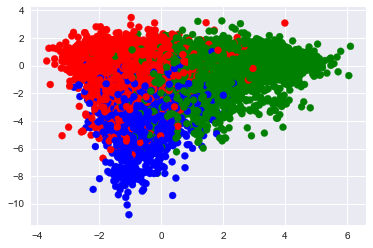

In [87]:
plot_df = pd.DataFrame(plot_df)
colors = {0:'red', 1:'blue', 2:'green'}

plt.scatter(plot_df.iloc[:,0], plot_df.iloc[:,1], 
            c=plot_df.iloc[:,2].apply(lambda x: colors[x]))

Nice seperation already but let's look at the density plots to see which class we can predict versus the rest.

In [88]:
target_0 = plot_df[plot_df.iloc[:,2] == 0] # functional
target_1 = plot_df[plot_df.iloc[:,2]  == 1] # functional needs repair
target_2 = plot_df[plot_df.iloc[:,2]  == 2] # non functional

First LDA1

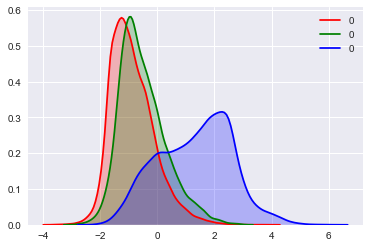

In [89]:
sns.kdeplot(target_0.iloc[:,0], shade=True, color='r')
sns.kdeplot(target_1.iloc[:,0], shade=True, color='g')
sns.kdeplot(target_2.iloc[:,0], shade=True, color='b')

So there is a very clear seperation between classes with LDA1.

- Red and Green are "functional" and "functional needs repair" 
- Blue is "non functional"

Let's run a random forest on LDA1 to predict "non functional" vs the rest.

And LDA2

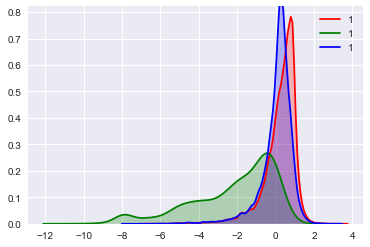

In [90]:
sns.kdeplot(target_0.iloc[:,1], shade=True, color='r')
sns.kdeplot(target_1.iloc[:,1], shade=True, color='g')
sns.kdeplot(target_2.iloc[:,1], shade=True, color='b')

Less clear but still useful seperation. Perhaps we can predict green ("functional needs repair") with LDA2.

Let's quickly check the accuracy of this fitted LDA.

In [101]:
cv_accuracy(lda_fit2)

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  9.9min finished


array([0.77543978, 0.77813315, 0.78114478, 0.77727273, 0.77201549])

Not very great. This obviously has both LDA features in there which does not maximize the seperation. Let's run a PCA on our set and combine this with our LDA1 to test whether we can improve this.

In [91]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

pca_fit = make_pipeline(MaxAbsScaler(), 
                       pca).fit_transform(X)

In [92]:
pca_plot = np.column_stack((pca_fit, y_plot))

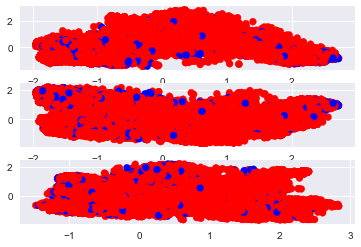

In [93]:
plot_df = pd.DataFrame(pca_plot)
colors = {0:'red', 1:'blue', 2:'red'}

plt.subplot(3,1,1)
plt.scatter(plot_df.iloc[:,0], plot_df.iloc[:,1], 
            c=plot_df.iloc[:,3].apply(lambda x: colors[x]))


plt.subplot(3,1,2)
plt.scatter(plot_df.iloc[:,0], plot_df.iloc[:,2], 
            c=plot_df.iloc[:,3].apply(lambda x: colors[x]))


plt.subplot(3,1,3)
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], 
            c=plot_df.iloc[:,3].apply(lambda x: colors[x]))

PCA plots

In [94]:
target_0_1 = plot_df[plot_df.iloc[:,3].isin([0,2])] # functional & functional needs repair
target_2 = plot_df[plot_df.iloc[:,3]  == 1] # non functional

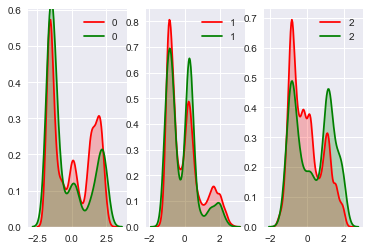

In [95]:
#PC1
plt.subplot(1,3,1)
sns.kdeplot(target_0_1.iloc[:,0], shade=True, color='r')
sns.kdeplot(target_2.iloc[:,0], shade=True, color='g')

#PC2
plt.subplot(1,3,2)
sns.kdeplot(target_0_1.iloc[:,1], shade=True, color='r')
sns.kdeplot(target_2.iloc[:,1], shade=True, color='g')

#PC3
plt.subplot(1,3,3)
sns.kdeplot(target_0_1.iloc[:,2], shade=True, color='r')
sns.kdeplot(target_2.iloc[:,2], shade=True, color='g')

In [96]:
lda_y = y.replace({"functional":0, "functional needs repair":0,
                  "non functional":1})

In [97]:
lda_pca_X = np.column_stack((lda_fit[:,0], pca_fit[:,0], pca_fit[:,1]))

In [102]:
rf_lda1 = make_pipeline(MaxAbsScaler(),
                   RandomForestClassifier(n_estimators = 160,
                                         min_samples_split = 6,
                                         n_jobs = 3)).fit(X=lda_pca_X, 
                                                          y=np.ravel(lda_y))

cv_accuracy(rf_lda1).mean()

[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  4.5min finished


0.8115321280633756

Decent but not great performance with LDA1 and PCA1 and PCA2. It seems that even with this clear seperation a general random forest has a hard time seperating between the two new classes. 

Let's perhaps try QDA.

### 4.2.2 QDA
LDA assumes that all the classes in the data have the same covariance matrix. This can be an issue and thus we also try QDA which does not make this assumption. In general LDA is better for the bias-variance tradeoff when there are not a lot of samples since getting a less flexible model might reduce variance a lot - however in this case we have a lot of training samples so getting a more flexible model might be beneficial. 

In [104]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

qda_fit = make_pipeline(MaxAbsScaler(),
                         qda).fit(X, y)

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [110]:
score = qda.score(X, y)
score

0.3452020202020202

This seems a bit strange as a score. Even though pure accuracy score on a multi-class problem is a harsh metric we would still expect it to be higher than the LDA model simply due to the increase in flexibility. More time would be needed to investigate this.

## 4.3 SVM
I'm using LinearSVC because it scales better with large datasets due to its pure linear kernel use. rbf kernel was attempted too but due to the size of the dataset this did not work out due to computational time.

In [124]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

lin_svc = make_pipeline(MaxAbsScaler(),
                        LinearSVC())

lin_params = {'linearsvc__C':[0.08, 0.1]}

svc_grid = GridSearchCV(estimator= lin_svc, param_grid = lin_params, 
                        cv=kfold2, scoring = 'accuracy', verbose = 10)

svc_grid.fit(X, y)
print(svc_grid.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] linearsvc__C=0.08 ...............................................


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... linearsvc__C=0.08, score=0.7928451178451178, total=  10.9s
[CV] linearsvc__C=0.08 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... linearsvc__C=0.08, score=0.7851671016078795, total=  12.3s
[CV] linearsvc__C=0.08 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.5s remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... linearsvc__C=0.08, score=0.7825574543311726, total=  12.3s
[CV] linearsvc__C=0.08 ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.5s remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... linearsvc__C=0.08, score=0.7856541505303923, total=  12.7s
[CV] linearsvc__C=0.08 ...............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ...... linearsvc__C=0.08, score=0.7902845596901835, total=  12.9s
[CV] linearsvc__C=0.1 ................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... linearsvc__C=0.1, score=0.7934343434343434, total=  13.0s
[CV] linearsvc__C=0.1 ................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... linearsvc__C=0.1, score=0.7852512837780958, total=  13.1s
[CV] linearsvc__C=0.1 ................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ....... linearsvc__C=0.1, score=0.7828941830120381, total=  13.5s
[CV] linearsvc__C=0.1 ................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.1min remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ linearsvc__C=0.1, score=0.786748610877252, total=  12.1s
[CV] linearsvc__C=0.1 ................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.3min remaining:    0.0s
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] ........ linearsvc__C=0.1, score=0.790452938205085, total=  13.6s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.6min finished
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'linearsvc__C': 0.1}


Gridsearching svc C paramater gives 0.1 as best value.

In [118]:
lin_svc = LinearSVC(C = 0.1)

svc_fit = make_pipeline(MaxAbsScaler(),
                        lin_svc.fit(X, y))
                        
cv_accuracy(svc_fit).mean()

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   37.4s finished


0.7871549483678548

The scores aren't very impressive but can perhaps be used in a combined model. We used it in one iteration of the stacking generalizations.

In [119]:
from sklearn.externals import joblib
joblib.dump(svc_fit, "svc_fit.pkl") 

['svc_fit.pkl']

## 4.4 Xgboost

In [43]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold

kfold2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

In [44]:
y['status_group'].value_counts()

functional                 32258
non functional             22820
functional needs repair     4316
Name: status_group, dtype: int64

In [45]:
y_temp = y['status_group']
y_temp = y_temp.replace({"functional":0, 
                         "non functional":1,
                         "functional needs repair":2})

#### Bayesian optimization for the hyperparameters
The bayesian optimization of xgboost paramets consists of three parts. 

First I build a generic xgboost function that initializes the parameters and creates a scoring function that is inverted to let the bayes_opt package optimize it.

In [46]:
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from bayes_opt import BayesianOptimization

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['cosample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['eta'] = 0.1
    params['silent'] = False
    params['eval_metric'] ='mlogloss'
    params['verbose_eval'] = True
    params['objective'] ='multi:softmax'
    params['num_class'] = 3
    params['folds'] = kfold2
    
    cv_result = xgb.cv(params, xgtrain, num_boost_round=num_rounds,
             seed=42,
             callbacks=[xgb.callback.early_stop(50)])

    return -cv_result['test-mlogloss-mean'].values[-1]

Now I run the optimizer, first it sets up 10 initial point in the n-dimensional hyperparameter space (n equal to amount of paramters of xgboost) and then it will generate functions that fit these points to find the highest probability areas for minimizing logloss.

In [135]:
print('preparing data')
xgtrain = xgb.DMatrix(X, label=y_temp)
params = {}
print('setting up optimizer')
num_rounds = 10
random_state = 42
kfold2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)

XGB_BO = BayesianOptimization(xgb_evaluate, {
                                     'max_depth': (5, 15),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (1, 20),
                                     'subsample': (0.5, 1.0),
                                     'colsample_bytree' :(0.1, 1.0),
                                     'alpha' : (0,10)
                                    })

XGB_BO.maximize(init_points = 10, n_iter = 50)


preparing data
setting up optimizer
Initialization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
    1 | 05m49s |   -0.74474 |    9.8875 |             0.1277 |    5.3171 |     11.2137 |             4.3449 |      0.7298 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
    2 | 03m13s |   -0.77818 |    3.1312 |             0.2217 |    3.8831 |      5.2359 |            15.1299 |      0.6866 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 round

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.03386156e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.02927593e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


 |             0.6863 |    0.7829 |      6.6950 |            12.2894 |      0.8182 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   11 | 07m06s |   -0.71123 |    0.0005 |             0.9952 |    1.0891 |     14.1177 |            19.9108 |      0.5221 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   12 | 06m35s |   -0.68188 |    0.1791 |             0.8672 |    0.0289 |     14.9751 |             1.0625 |      0.8395 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

W

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.53317229e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   16 | 05m44s |   -0.68381 |    0.6594 |             0.9125 |    0.5395 |     14.2378 |             1.3970 |      0.9961 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.20344921e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   17 | 05m56s |   -0.68324 |    0.0469 |             0.2947 |    0.3128 |     14.3979 |             3.1466 |      0.9903 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   18 | 146m53s |   -0.68244 |    0.4751 |             0.1344 |    0.6865 |     14.8832 |             1.1532 |      0.9334 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.24900191e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   19 | 06m02s |   -0.68489 |    0.6143 |             0.1812 |    0.4691 |     14.9502 |             2.0922 |      0.9965 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   20 | 03m59s |   -0.74702 |    0.0279 |             0.1041 |    0.0489 |      7.8187 |             1.1727 |      0.7867 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.35398146e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   21 | 06m45s |   -0.72903 |    9.9433 |             0.7344 |    1.0971 |     14.2828 |            19.5937 |      0.9766 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   22 | 06m09s |   -0.70383 |    0.0643 |             1.0000 |    5.9120 |     15.0000 |             9.7704 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   23 | 06m13s |   -0.68785 |    0.2158 |             0.6919 |    2.7955 |     14.5833 |             1.4425 |      0.9278 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.13269571e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   24 | 07m25s |   -0.70230 |    0.1495 |             0.8813 |    0.1366 |     12.4119 |            10.2728 |      0.9319 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.59362716e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   25 | 08m08s |   -0.72146 |    0.0368 |             0.2582 |    9.6540 |     14.2429 |            19.9196 |      0.9401 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   26 | 08m08s |   -0.68233 |    0.2000 |             0.5915 |    0.4919 |     14.2411 |             1.0915 |      0.8274 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   27 | 06m26s |   -0.68796 |    0.1728 |             0.9970 |    1.4182 |     13.4840 |             1.3148 |      0.9325 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   28 | 02m47s |   -0.78099 |    9.6369 |             0.1530 |    9.8646 |      5.3703 |             1.0985 |      0.9728 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   29 | 02m53s |   -0.78147 |    9.3524 |             0.1000 |   10.0000 |      5.0000 |            17.9239 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   30 | 06m26s |   -0

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00100949]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   31 | 06m09s |   -0.68874 |    0.1766 |             0.1298 |    0.1226 |     13.1635 |             1.1374 |      0.7978 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   32 | 03m17s |   -0.78193 |   10.0000 |             1.0000 |    0.0010 |      5.0000 |             1.7215 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   33 | 07m24s |   -0.76548 |   10.0000 |             1.0000 |   10.0000 |     14.1840 |             1.0898 |      0.5000 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   34 | 02m52s |   -0.77964 |    8.6298 |             0.9521 |    0.2446 |      5.2449 |            19.9362 |      0.8931 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   35 | 04m56s |   -0

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.05037268e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.50590848e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   37 | 06m27s |   -0.70030 |    0.5114 |             0.3569 |    0.5062 |     14.8208 |            19.7942 |      0.9870 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00183932]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   38 | 06m54s |   -0.69414 |    0.1148 |             0.1084 |    3.5563 |     14.1911 |             6.0050 |      0.9343 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([7.26968201e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00082249]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   39 | 07m37s |   -0.69766 |    0.1373 |             0.3593 |    0.0215 |     14.7019 |            13.5613 |      0.7799 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.11408614e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   40 | 07m47s |   -0.68125 |    0.1021 |             0.4710 |    0.0539 |     14.8944 |             1.1837 |      0.8366 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   41 | 07m31s |   -0.68142 |    0.2086 |             0.2297 |    1.3018 |     14.5204 |             1.5965 |      0.9319 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   42 | 06m54s |   -0.72370 |    9.1574 |             0.7199 |    0.0426 |     14.9527 |            11.1752 |      0.9785 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00038234]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   43 | 06m38s |   -0.68130 |    0.1620 |             0.9877 |    0.9795 |     14.9227 |             1.2498 |      0.9219 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   44 | 06m40s |   -0.72061 |    0.1320 |             0.1616 |    9.9934 |     14.6934 |             7.7979 |      0.9274 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   45 | 03m04s |   -0.77690 |    0.2003 |             0.1046 |    9.8293 |      5.1869 |             1.0439 |      0.8223 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00027471]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   46 | 06m17s |   -0.68194 |    0.2647 |             0.5451 |    0.6196 |     14.4228 |             1.7754 |      0.9616 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0012593]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 49, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0003291]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00014601]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted varia

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   47 | 05m49s |   -0.68191 |    0.0993 |             0.1541 |    0.7553 |     14.8014 |             1.7016 |      0.9921 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00237257]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 2, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.75117782e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 47, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   48 | 03m02s |   -0.77603 |    0.0958 |             0.4157 |    0.1973 |      5.0484 |            19.9790 |      0.8247 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   49 | 06m43s |   -0.74586 |   10.0000 |             1.0000 |   10.0000 |     15.0000 |             9.6336 |      1.0000 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   50 | 07m20s |   -0.72082 |    4.3993 |             0.9862 |    3.4581 |     14.6942 |             7.9868 |      0.7712 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   51 | 07m03s |   -0

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   52 | 16m29s |   -0.71289 |    3.9971 |             0.8887 |    0.3154 |     14.9893 |            16.0110 |      0.9633 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   53 | 52m41s |   -0.73757 |    0.5684 |             0.1219 |    9.9234 |     14.8251 |            14.4420 |      0.5740 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   54 | 03m24s |   -0.77211 |    9.9779 |             0.1694 |    9.8261 |      6.0676 |             9.2036 |      0.8923 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   55 | 07m02s |   -0.71792 |    3.0290 |             0.1019 |    0.0861 |     12.3766 |             6.2439 |      0.5657 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   56 | 06m27s |   -0.71641 |    9.8484 |             0.7410 |    0.0309 |     14.5415 |             2.1324 |      0.9978 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   57 | 06m19s |   -0.73669 |    3.9914 |             0.9917 |    9.9924 |     12.1610 |             5.7363 |      0.9072 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   58 | 06m33s |   -0.72187 |    3.0320 |             0.9212 |    5.2001 |     13.8639 |            19.8846 |      0.9533 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   59 | 07m09s |   -0.69075 |    0.9123 |             0.9514 |    0.4227 |     14.8667 |             5.8872 |      0.8774 | 
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
   60 | 05m53s |   -0

In [136]:
print('-'*50)
print('Final Results')
print('Maximum XGBOOST value: %f' % XGB_BO.res['max']['max_val'])
print('Best XGBOOST parameters: ', XGB_BO.res['max']['max_params'])

--------------------------------------------------
Final Results
Maximum XGBOOST value: -0.677033
Best XGBOOST parameters:  {'max_depth': 15.0, 'gamma': 0.0010000020401352745, 'min_child_weight': 1.0000000347899616, 'subsample': 1.0, 'colsample_bytree': 0.1, 'alpha': 2.5758635229200662e-08}


Now I run the actual model with the optimized parameters.

In [59]:
xgb_opt = XGBClassifier(learning_rate =0.01, n_estimators=3000, 
                        max_depth=15,min_child_weight=1,
                        gamma=0.0010000020401352745,subsample=1.0,
                        colsample_bytree=0.1, 
                        reg_alpha = 2.5758635229200662e-08,
                        objective= 'multi:softmax', num_class = 3,
                        nthread=4,scale_pos_weight=1,seed=27, 
                        silent = False)

xgb_opt_model = xgb_opt.fit(X,y)

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Saving the model

In [ ]:
from sklearn.externals import joblib
joblib.dump(xgb_opt_model, "xgb_opt_model.pkl") 

Scoring the model.

In [121]:
from sklearn.externals import joblib
xgb_opt_imported = joblib.load("xgb_opt2.pkl") 

In [60]:
cv_accuracy(xgb_opt_imported).mean()

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

0.81627773974942

- First xgboost : 0.813367
- 2nd xgboost + outliers removed: 0.816277

# 5. Ensemble methods
I'll be using the mlxtend package to do classifier ensembles.

I'll do a few things here:

- stacking of models - probability based voting (through sklearn votingclassifier)
- fit a meta classifier based on a few underlying models

## 5.1 Stacking Generalizations

I'll build a meta-classifier through a process called stacking generalizations which trains a model on a part of the training set (it gets split first into a new training set and a holdout set). Then the algorithm test these models on the holdout set and uses these predictions (called out-of-fold predictions) as input for the 'meta model'. Below is a grahpical representation of the process.

In [65]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url = "http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier_files/stacking_cv_classification_overview.png")

There's two ways to do this. First training on the hard predictions of the underlying models and secondly by using the predicted probabilities instead. I don't employ scoring here anymore because of computational limitations.

### 5.2.1 Simple stacking generalizations

In [47]:
from mlxtend.classifier import StackingCVClassifier

clf1 = XGBClassifier(learning_rate =0.01, n_estimators=3000, 
                        max_depth=15,min_child_weight=1,
                        gamma=0.0010000020401352745,subsample=1.0,
                        colsample_bytree=0.1, 
                        reg_alpha = 2.5758635229200662e-08,
                        objective= 'multi:softmax', num_class = 3,
                        nthread=1,scale_pos_weight=1,seed=27, 
                        silent = False)

clf2 = make_pipeline(MaxAbsScaler(),
                   RandomForestClassifier(n_estimators = 160,
                                         min_samples_leaf = 1,
                                          min_samples_split = 6))

stack_gen = StackingCVClassifier(classifiers=[clf1, clf2],
                                meta_classifier=clf1, verbose=2,
                                use_features_in_secondary=True)


#prepare dfs
stackX = np.array(X)
stacky = np.array(y_temp)

In [107]:
stack_gen_model = stack_gen.fit(stackX, stacky)

Fitting 2 classifiers...
Fitting classifier1: xgbclassifier (1/2)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.1, gamma=0.0010000020401352745,
       learning_rate=0.01, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=None, n_estimators=3000, n_jobs=1,
       nthread=1, num_class=3, objective='multi:softmax', random_state=0,
       reg_alpha=2.5758635229200662e-08, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=False, subsample=1.0)
Training and fitting fold 1 of 2...


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training and fitting fold 2 of 2...


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting classifier2: pipeline (2/2)
Pipeline(memory=None,
     steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Training and fitting fold 1 of 2...
Training and fitting fold 2 of 2...


So as to not lose progress I export my trained models to avoid having to retrain (the above code takes about 16 hours to run on my laptop)

In [109]:
from sklearn.externals import joblib
joblib.dump(stack_gen_model, "stack_model_rf&xgb.pkl") 

['stack_model_rf&xgb.pkl']

In [136]:
from sklearn.externals import joblib
stack_model_imported = joblib.load("stack_model_rf&xgb.pkl") 

In [137]:
xgb_opt2 = stack_model_imported.clfs_[0]
rf_stack = stack_model_imported.clfs_[1]

In [140]:
from sklearn.externals import joblib
joblib.dump(xgb_opt2, "xgb_opt2.pkl") 

['xgb_opt2.pkl']

## 5.2 Ensemble Voting Classification
I employed two methods here. Probability based voting and hard voting. In the end we went with hard voting mainly due to the fact that linearSVC does not have a predict_proba method which makes implementation hard.

# 5.2.1 Hard voting

In [ ]:
from sklearn.ensemble import VotingClassifier

clf2 = make_pipeline(MaxAbsScaler(),
                   RandomForestClassifier(n_estimators = 160,
                                         min_samples_leaf = 1,
                                          min_samples_split = 6))

clf3 = XGBClassifier(learning_rate =0.01, n_estimators=3000, 
                        max_depth=15,min_child_weight=1,
                        gamma=0.0010000020401352745,subsample=1.0,
                        colsample_bytree=0.1, 
                        reg_alpha = 2.5758635229200662e-08,
                        objective= 'multi:softmax', num_class = 3,
                        nthread=1,scale_pos_weight=1,seed=27, 
                        silent = False)



clf1 = StackingCVClassifier(classifiers=[clf2, clf3],
                                meta_classifier=clf3, verbose=2,
                                use_features_in_secondary=False)


eclf = VotingClassifier(estimators = [('stackgen', clf1),
                                      ('rf', clf2), ('xgb', clf3)],
                       voting = 'soft', weights = [6,1,3])

eclf_fit = eclf.fit(np.array(X), np.array(y))

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting 2 classifiers...
Fitting classifier1: pipeline (1/2)
Pipeline(memory=None,
     steps=[('maxabsscaler', MaxAbsScaler(copy=True)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Training and fitting fold 1 of 2...
Training and fitting fold 2 of 2...
Fitting classifier2: xgbclassifier (2/2)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.1, gamma=0.0010000020401352745,
       learning_rate=0.01, max_delta_step=0, max_depth=15,
       min_child_weight=1, missing=None, n_estimators=3000, n_jobs=1,
       nthread=1, num_class=3, objective=

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Training and fitting fold 2 of 2...


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [132]:
from sklearn.externals import joblib
joblib.dump(eclf_fit, "large_voter2.pkl") 

['large_voter2.pkl']

In [134]:
large_voter2 = joblib.load("large_voter2.pkl") 

As a very rough scoring metric I use the un-crossvalidated accuracy. This is obviously incorrect but a correct scoring (using the earlier defined scorer - cv_accuracy - function) is impossible due to computational requirements.

In [135]:
large_voter2.score(np.array(X), np.array(y))

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9376199616122841

# 6. Predictions
## 6.1 Making predictions
Below are the prediction sets for the models that were used. In the end best performance was obtained with a Stacked Generalizations model of Xgboost and randomforest with a xgboost meta-model. I believe more performance could be eeked out the voting classifier when playing with different weights. Unfortunately this became computationally completely unfeasible.

### Random Forest

In [48]:
rf_preds = rf2.predict(testing_features)

### Optimized XGBoost

In [61]:
xgb_preds = xgb_opt_model.predict(testing_features)

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Stacked Generalizations

In [114]:
stack_gen_preds = stack_gen_model.predict(np.array(testing_features))

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [122]:
stack_gen_preds = pd.DataFrame(stack_gen_preds)

In [124]:
stack_gen_preds[0] = stack_gen_preds[0].replace({0:"functional",
                                                 1:"non functional",
                                                 2:"functional needs repair"})

### Stacked / XGB / RF ensemble

In [136]:
voting_preds = large_voter2.predict(np.array(testing_features))

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 6.2 Preparing submission file

In [138]:
submission = pd.read_csv("SubmissionFormat.csv")

In [141]:
submission

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional
5,52449,functional
6,24806,non functional
7,28965,non functional
8,36301,non functional
9,54122,functional


In [140]:
submission.iloc[:,1] = voting_preds

In [142]:
submission.to_csv("submission15.csv", index=False)